# Adding Work Location to individuals

Assigning individuals to work locations

We follow the steps outlined in this [github issue](https://github.com/Urban-Analytics-Technology-Platform/acbm/issues/12)

In [2]:
import logging
import pickle as pkl
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from libpysal.weights import Queen
from shapely.geometry import Point

from acbm.assigning.assigning import (
    fill_missing_zones,
    filter_matrix_to_boundary,
    get_activities_per_zone,
    get_possible_zones,
    intrazone_time,
    replace_intrazonal_travel_time,
    select_activity,
    select_zone,
    zones_to_time_matrix,
)
from acbm.assigning.work import WorkZoneAssignment

# to display aall columns
pd.set_option('display.max_columns', None)




INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load in the data


### Activity chains

In [3]:
# read parquet file
activity_chains = pd.read_parquet('../data/interim/matching/spc_with_nts_trips.parquet')
activity_chains.head(10)

id  household                                           location  \
0  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
1  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
2  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
3  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
4  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
5  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
6  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
7  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
8  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   
9  1193050     479338  {'x': -1.3864760398864746, 'y': 53.94084167480...   

    pid_hs       msoa         oa             members sic1d2007  sic2d2007  \
0  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
1  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
2  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
3  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
4  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
5  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
6  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
7  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
8  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   
9  2910658  E02002330  E00059012  [1193050, 1193051]         Q       86.0   

   pwkstat  salary_yearly  salary_hourly             hid  accommodation_type  \
0        1   16777.279297           8.72  E02002330_0029                 1.0   
1        1   16777.279297           8.72  E02002330_0029                 1.0   
2        1   16777.279297           8.72  E02002330_0029                 1.0   
3        1   16777.279297           8.72  E02002330_0029                 1.0   
4        1   16777.279297           8.72  E02002330_0029                 1.0   
5        1   16777.279297           8.72  E02002330_0029                 1.0   
6        1   16777.279297           8.72  E02002330_0029                 1.0   
7        1   16777.279297           8.72  E02002330_0029                 1.0   
8        1   16777.279297           8.72  E02002330_0029                 1.0   
9        1   16777.279297           8.72  E02002330_0029                 1.0   

   communal_type  num_rooms  central_heat  tenure  num_cars  sex  age_years  \
0            NaN        6.0          True     1.0         2    1         60   
1            NaN        6.0          True     1.0         2    1         60   
2            NaN        6.0          True     1.0         2    1         60   
3            NaN        6.0          True     1.0         2    1         60   
4            NaN        6.0          True     1.0         2    1         60   
5            NaN        6.0          True     1.0         2    1         60   
6            NaN        6.0          True     1.0         2    1         60   
7            NaN        6.0          True     1.0         2    1         60   
8            NaN        6.0          True     1.0         2    1         60   
9            NaN        6.0          True     1.0         2    1         60   

   ethnicity  nssec8  index_right  salary_yearly_hh  salary_yearly_hh_cat  \
0          1     2.0        55630       24067.22998                     1   
1          1     2.0        55630       24067.22998                     1   
2          1     2.0        55630       24067.22998                     1   
3          1     2.0        55630       24067.22998                     1   
4          1     2.0        55630       24067.22998                     1   
5          1     2.0        55630       24067.22998                     1   
6          1     2.0        55630

#### Data preparation: Mapping trip purposes

Rename columns and map actual modes and trip purposes to the trip table. 

Code taken from: https://github.com/arup-group/pam/blob/main/examples/07_travel_survey_to_matsim.ipynb

In [4]:
activity_chains = activity_chains.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

Check the NTS glossary [here](https://www.gov.uk/government/statistics/national-travel-survey-2022-technical-report/national-travel-survey-2022-technical-report-glossary) to understand what the trip purposes mean.

add an escort column

In [5]:
mode_mapping = {
    1: "walk",
    2: "cycle",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "car",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop_food",  #'Food shopping',
    5: "shop_other",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other_eat_drink",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other_eat_drink",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other_social",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other_sport",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort_home",  #'Escort home',
    18: "escort_work",  #'Escort work',
    19: "escort_work",  #'Escort in course of work',
    20: "escort_education",  #'Escort education',
    21: "escort_shopping",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


activity_chains["mode"] = activity_chains["mode"].map(mode_mapping)

activity_chains["oact"] = activity_chains["oact"].map(purp_mapping)

activity_chains["dact"] = activity_chains["dact"].map(purp_mapping)

### Study area boundaries

Read in the study area boundaries only (not the whole country)

In [6]:
# SQL-like clause for filtering
where_clause = "MSOA21NM LIKE '%Leeds%'"

boundaries = gpd.read_file('../data/external/boundaries/oa_england.geojson',
                           where = where_clause)

boundaries.head(10)

OBJECTID     OA21CD                              GlobalID   LSOA21CD  \
0     53507  E00056750  0fd0c6c3-be95-44c9-ae9b-5046e36644d3  E01011269   
1     53508  E00056751  358b1d5c-1301-4913-9270-f93a104a7e01  E01011272   
2     53509  E00056752  8ed9b868-29c2-404d-9fa4-58b5a2481f8f  E01011273   
3     53510  E00056753  33fe3f5a-898c-41f6-8b42-9d8a5276a275  E01011274   
4     53511  E00056754  8d53d2d4-ca6a-4ddb-9d2a-9dd66bdcf42c  E01011276   
5     53512  E00056755  0d97ece5-e0e7-4e83-9237-730a5863b686  E01011274   
6     53513  E00056756  50be522b-5687-4538-8d86-72eb73133fcb  E01011274   
7     53514  E00056757  9ec0e325-dd79-4a8a-b886-18d5127ee5f7  E01011276   
8     53515  E00056758  a5138f04-7856-413c-8abb-fb3369dff319  E01011277   
9     53516  E00056759  772cb09b-1bdc-4cc9-8b26-9032b235e9d8  E01011277   

     LSOA21NM   MSOA21CD   MSOA21NM   LEP22CD1           LEP22NM1    LAD22CD  \
0  Leeds 011B  E02002340  Leeds 011  E37000062  Leeds City Region  E08000035   
1  Leeds 009D  E02002338  Leeds 009  E37000062  Leeds City Region  E08000035   
2  Leeds 010B  E02002339  Leeds 010  E37000062  Leeds City Region  E08000035   
3  Leeds 010C  E02002339  Leeds 010  E37000062  Leeds City Region  E08000035   
4  Leeds 011C  E02002340  Leeds 011  E37000062  Leeds City Region  E08000035   
5  Leeds 010C  E02002339  Leeds 010  E37000062  Leeds City Region  E08000035   
6  Leeds 010C  E02002339  Leeds 010  E37000062  Leeds City Region  E08000035   
7  Leeds 011C  E02002340  Leeds 011  E37000062  Leeds City Region  E08000035   
8  Leeds 014A  E02002343  Leeds 014  E37000062  Leeds City Region  E08000035   
9  Leeds 014A  E02002343  Leeds 014  E37000062  Leeds City Region  E08000035   

  LAD22NM    rgn22cd                   rgn22nm   ctry22cd ctry22nm  \
0   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
1   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
2   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
3   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
4   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
5   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
6   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
7   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
8   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   
9   Leeds  E12000003  Yorkshire and The Humber  E92000001  England   

                                            geometry  
0  MULTIPOLYGON (((420675.101 441465.476, 420653....  
1  MULTIPOLYGON (((419790.406 441141.836, 419787....  
2  MULTIPOLYGON (((420251.937 441467.716, 420238....  
3  MULTIPOLYGON (((421132.508 441296.621, 421124....  
4  MULTIPOLYGON (((421306.651 441017.719, 421303....  
5  MULTIPOLYGON (((420713.932 440962.034, 420706....  
6  MULTIPOLYGON (((420841.300 440661.858, 420810....  
7  MULTIPOLYGON (((421093.710 440588.597, 421129....  
8  MULTIPOLYGON (((420171.984 440679.852, 420135....  
9  MULTIPOLYGON (((419744.573 440480.562, 419779....

<Axes: >

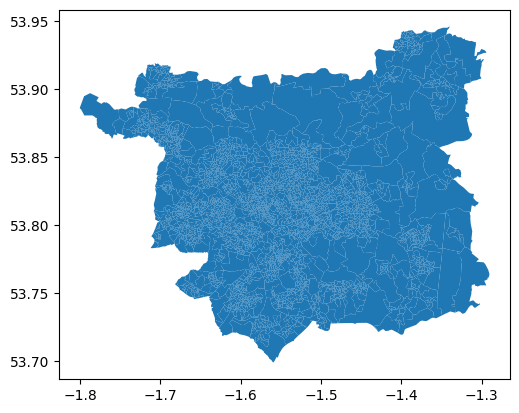

In [7]:
# convert boundaries to 4326
boundaries = boundaries.to_crs(epsg=4326)
# plot the geometry
boundaries.plot()

#### Assign activity home locations to boundaries zoning system 

Convert location column in activity_chains to spatial column

In [8]:
# turn column to shapely point
activity_chains['location'] = activity_chains['location'].apply(lambda loc: Point(loc['x'], loc['y']))

# Convert the DataFrame into a GeoDataFrame, and assign a coordinate reference system (CRS)
activity_chains = gpd.GeoDataFrame(activity_chains, geometry='location')
activity_chains.crs = "EPSG:4326" # I assume this is the crs


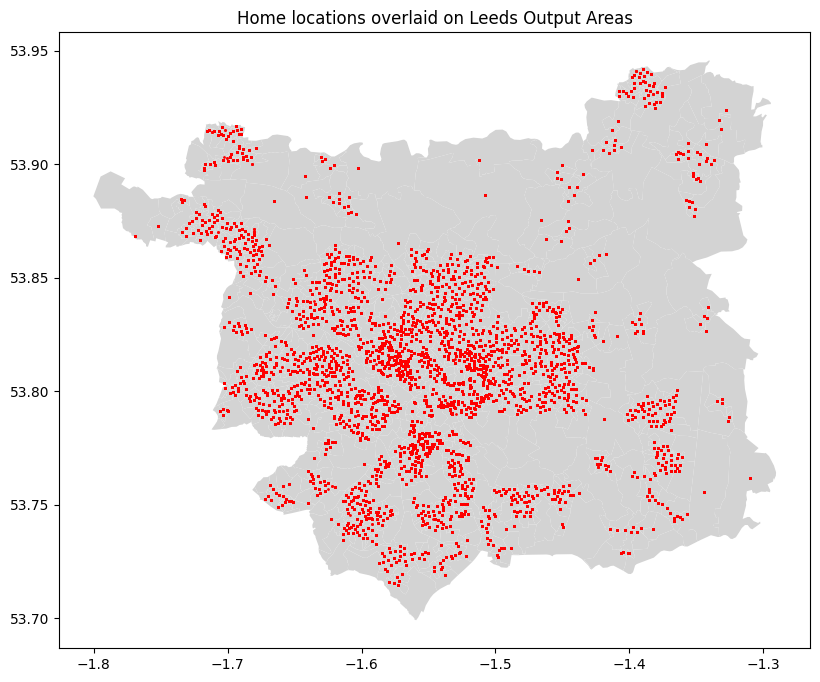

In [9]:
# plot the boundaries gdf and overlay them with the activity_chains gdf
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
activity_chains.plot(ax=ax, color='red', markersize=1)
plt.title('Home locations overlaid on Leeds Output Areas')
plt.show()


In [10]:
#remove index_right column from activity_chains if it exists
if 'index_right' in activity_chains.columns:
    activity_chains = activity_chains.drop(columns='index_right')


# Spatial join to identify which polygons each point is in
activity_chains = gpd.sjoin(activity_chains, boundaries[["OA21CD", "geometry"]], how='left', predicate='within')
activity_chains = activity_chains.drop('index_right', axis=1)


### Travel time matrix for study area

Travel time data between geographical areas (LSOA, OA, custom hexagons etc) is used to determine feasible work / school locations for each individual. The travel times are compared to the travel times of the individual's actual trips from the nts (`tst`/`TripStart` and `tet`/`TripEnd`)

In [ ]:
travel_times = pd.read_parquet('../data/external/travel_times/oa/travel_time_matrix_acbm.parquet')
travel_times.head(10)

In [ ]:
travel_times["combination"].unique()

Add area code to travel time data

In [ ]:
# convert from_id and to_id to int to match the boundaries data type
travel_times = travel_times.astype({'from_id': int, 'to_id': int})

# merge travel_times with boundaries
travel_times = travel_times.merge(boundaries[['OBJECTID', 'OA21CD']], left_on='from_id', right_on='OBJECTID', how='left')
travel_times = travel_times.drop(columns='OBJECTID')

travel_times = travel_times.merge(boundaries[['OBJECTID', 'OA21CD']], left_on='to_id', right_on='OBJECTID', how='left', suffixes=('_from', '_to'))
travel_times = travel_times.drop(columns='OBJECTID')

travel_times.head(10)

#### Travel distance matrix

Some areas aren't reachable by specific modes. This can cause problems later on in get_possible_zones() as we won't be able to assign some activities to zones. We create a travel distance matrix to fall back on when there are no travel time calculations

In [ ]:
travel_time_estimates = zones_to_time_matrix(
    zones = boundaries,
    id_col = "OA21CD",
    to_dict = True
)

What does the data look like?

In [ ]:
# Get an iterator over the dictionary items and then print the first n items
items = iter(travel_time_estimates.items())

for i in range(5):
    print(next(items))

In [ ]:
with open('../data/interim/assigning/travel_time_estimates.pkl', 'wb') as f:
    pkl.dump(travel_time_estimates, f)

#### Intrazonal trip times 

Intrazonal trips all have time = 0. Our `get_possible_zones` function finds zones that are within a specified % threshold from the reported time in the NTS. A threshold percentage from a non zero number never equals 0, so intrazonal trips are not found. The problem is also explained in this [github issue](https://github.com/Urban-Analytics-Technology-Platform/acbm/issues/30)

Below, we assign intrazonal trips a non-zero time based on the zone area

In [ ]:
# get intrazone travel time estimates per mode

intrazone_times = intrazone_time(boundaries)

# print first 10 items in the dictionary
items = iter(intrazone_times.items())

for i in range(10):
    print(next(items))

In [ ]:
# replace intrazonal travel times with estimates from intrazone_times

travel_times = replace_intrazonal_travel_time(travel_times= travel_times,
                                              intrazonal_estimates= intrazone_times,
                                              column_to_replace= 'travel_time_p50')



### Activity locations 

Activity locations are obtained from OSM using the [osmox](https://github.com/arup-group/osmox) package. Check the config documentation in the package and the `config_osmox` file in this repo

In [11]:
# osm data
osm_data = gpd.read_parquet('../data/external/boundaries/west-yorkshire_epsg_4326.parquet')

In [12]:
osm_data.head(10)

id activities                   geometry  units  levels  area  \
0    643657    transit  POINT (-1.50849 53.76233)    1.0     1.0     0   
1  20621535       home  POINT (-1.56566 53.81375)    1.0     2.0     0   
2  21591858       home  POINT (-1.63279 53.87138)    1.0     2.0     0   
3  27325240    transit  POINT (-1.66533 53.90971)    1.0     1.0     0   
4  27348238    transit  POINT (-1.63022 53.90354)    1.0     1.0     0   
5  27411630       home  POINT (-1.72353 53.90655)    1.0     2.0     0   
6  27415488       home  POINT (-1.74151 53.91351)    1.0     2.0     0   
7  27470976       home  POINT (-1.56251 53.90203)    1.0     2.0     0   
8  27475939  work,shop  POINT (-1.38550 53.92917)    1.0     1.0     0   
9  27563268    transit  POINT (-1.71095 53.91335)    1.0     1.0     0   

   floor_area  distance_to_nearest_transit  distance_to_nearest_shop  \
0         0.0                     0.000000                109.755337   
1         0.0                   198.493258                108.072976   
2         0.0                   969.484065                509.809989   
3         0.0                     0.000000                578.769135   
4         0.0                     0.000000                 95.392235   
5         0.0                   216.265895                986.041911   
6         0.0                   156.778571                187.697688   
7         0.0                   873.984192               1799.502624   
8         0.0                    13.691226                  0.000000   
9         0.0                     0.000000                521.696581   

   distance_to_nearest_medical  
0                  1883.754159  
1                   255.853754  
2                  2318.285507  
3                  1673.801938  
4                  3927.514412  
5                  1716.667311  
6                   448.685307  
7                  3250.842461  
8                   276.210958  
9                   653.499530

In [13]:
# get unique values for activties column
osm_data['activities'].unique()

array(['transit', 'home', 'work,shop', 'work,other', 'other',
       'medical,work', 'work,education_university', 'work',
       'home,education_school,work', 'shop,work,visit',
       'work,education_college', 'work,visit', 'shop,work',
       'work,education_kg', 'shop,other,work',
       'shop,other,visit,medical,work', 'education_school,work',
       'shop,visit,work', 'other,shop,visit,work',
       'shop,other,visit,work',
       'shop,other,visit,education_university,work', 'shop,home,work',
       'home,work', 'home,work,education_kg',
       'education_school,work,education_kg', 'work,other,shop',
       'medical,work,visit', 'work,education_university,other',
       'shop,work,education_kg', 'shop,work,other',
       'shop,education_college,visit,work', 'shop,visit,medical,work',
       'work,home,shop', 'work,shop,visit',
       'work,education_school,education_college',
       'work,education_school,shop', 'home,medical,work',
       'shop,medical,work', 'other,shop,work', 

In [14]:
# remove rows with activities = home OR transit

osm_data = osm_data[~osm_data['activities'].isin(['home', 'transit'])]
#osm_data = osm_data[osm_data['activities'] != 'home']
osm_data.head(10)


id    activities                   geometry  units  levels  area  \
8     27475939     work,shop  POINT (-1.38550 53.92917)    1.0     1.0     0   
10    27652981    work,other  POINT (-1.69244 53.90651)    1.0     2.0     0   
12    28164096     work,shop  POINT (-1.82254 53.92435)    1.0     2.0     0   
110  153723971     work,shop  POINT (-1.57273 53.82215)    1.0     2.0     0   
139  245978097         other  POINT (-1.91611 53.70566)    1.0     1.0     0   
140  249263552  medical,work  POINT (-1.52046 53.80794)    1.0     2.0     0   
437  297118278  medical,work  POINT (-1.65206 53.79918)    1.0     2.0     0   
479  300934441     work,shop  POINT (-1.57685 53.80400)    1.0     1.0     0   
519  301683143     work,shop  POINT (-1.54549 53.79791)    1.0    20.0     0   
520  301687728     work,shop  POINT (-1.54475 53.79911)    1.0     2.0     0   

     floor_area  distance_to_nearest_transit  distance_to_nearest_shop  \
8           0.0                    13.691226                  0.000000   
10          0.0                   105.789961                  5.964285   
12          0.0                    66.311834                  0.000000   
110         0.0                   230.009420                  0.000000   
139         0.0                    94.955463                252.129275   
140         0.0                    94.033714                 24.848189   
437         0.0                    99.999188                 17.405243   
479         0.0                    32.829653                  0.000000   
519         0.0                    99.261793                  0.000000   
520         0.0                    47.258007                  0.000000   

     distance_to_nearest_medical  
8                     276.210958  
10                     75.326150  
12                   4380.570764  
110                   289.321435  
139                   389.099716  
140                     0.000000  
437                     0.000000  
479                   436.760496  
519                   228.960072  
520                   117.268897

In [15]:
osm_data.activities.unique()

array(['work,shop', 'work,other', 'other', 'medical,work',
       'work,education_university', 'work', 'home,education_school,work',
       'shop,work,visit', 'work,education_college', 'work,visit',
       'shop,work', 'work,education_kg', 'shop,other,work',
       'shop,other,visit,medical,work', 'education_school,work',
       'shop,visit,work', 'other,shop,visit,work',
       'shop,other,visit,work',
       'shop,other,visit,education_university,work', 'shop,home,work',
       'home,work', 'home,work,education_kg',
       'education_school,work,education_kg', 'work,other,shop',
       'medical,work,visit', 'work,education_university,other',
       'shop,work,education_kg', 'shop,work,other',
       'shop,education_college,visit,work', 'shop,visit,medical,work',
       'work,home,shop', 'work,shop,visit',
       'work,education_school,education_college',
       'work,education_school,shop', 'home,medical,work',
       'shop,medical,work', 'other,shop,work', 'work,other,visit',
      

#### Get the number of activities in each zone 

Each zone has a different number of education facilities. We can use the number of facilities in each zone to determine the probability of each zone being chosen for each trip. We can then use these probabilities to randomly assign a zone to each trip.

The education facilities are disaggregated by type. For each activity, we use the individual's age to detemrine which of the following they are most likely to go to 

- "kindergarden": education_kg"
- "school": "education_school"
- "university": "education_university"
- "college": "education_college"

In [16]:
# spatial join to identify which zone each point in osm_data is in
osm_data_gdf = gpd.sjoin(osm_data, boundaries[["OA21CD", "geometry"]], how='inner', predicate='within')
osm_data_gdf.head(5)

id    activities                   geometry  units  levels  area  \
8     27475939     work,shop  POINT (-1.38550 53.92917)    1.0     1.0     0   
10    27652981    work,other  POINT (-1.69244 53.90651)    1.0     2.0     0   
110  153723971     work,shop  POINT (-1.57273 53.82215)    1.0     2.0     0   
140  249263552  medical,work  POINT (-1.52046 53.80794)    1.0     2.0     0   
437  297118278  medical,work  POINT (-1.65206 53.79918)    1.0     2.0     0   

     floor_area  distance_to_nearest_transit  distance_to_nearest_shop  \
8           0.0                    13.691226                  0.000000   
10          0.0                   105.789961                  5.964285   
110         0.0                   230.009420                  0.000000   
140         0.0                    94.033714                 24.848189   
437         0.0                    99.999188                 17.405243   

     distance_to_nearest_medical  index_right     OA21CD  
8                     276.210958         2148  E00059036  
10                     75.326150         1506  E00058349  
110                   289.321435         2448  E00170581  
140                     0.000000         1947  E00058809  
437                     0.000000         1632  E00058477

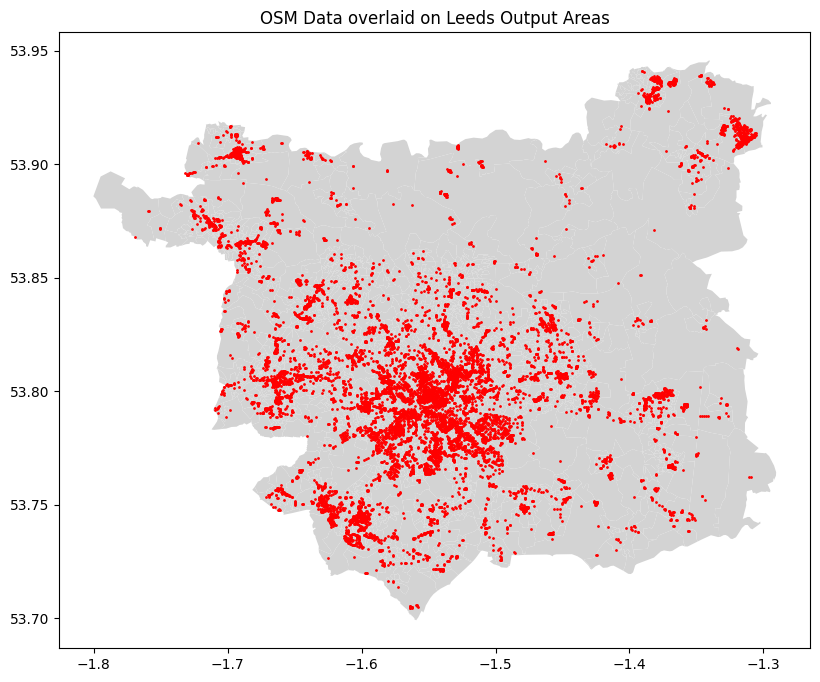

In [17]:
# plot the points and then plot the zones on a map
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
osm_data_gdf.plot(ax=ax, color='red', markersize=1)
plt.title('OSM Data overlaid on Leeds Output Areas')
plt.show()

In [18]:
activities_per_zone = get_activities_per_zone(
    zones = boundaries,
    zone_id_col = "OA21CD",
    activity_pts = osm_data,
    return_df = True
    )

activities_per_zone

OA21CD  counts  floor_area activity
0   E00056751       8      7552.0     work
1   E00056752      12     32255.0     work
2   E00056753      33     25607.0     work
3   E00056755       7      8647.0     work
4   E00056757       3      2058.0     work
..        ...     ...         ...      ...
84  E00170055       1        82.0     home
85  E00170474       1       556.0     home
86  E00170589       1       260.0     home
87  E00187025       2      2382.0     home
88  E00187084       1       408.0     home

[4002 rows x 4 columns]

### Commuting matrices (from 2021 census)

In [19]:
commute_level = "OA"  # "OA" or "MSOA" data

Clean the data 

In [20]:
if commute_level == "MSOA":
    print("Step 1: Reading in the zipped csv file")
    travel_demand = pd.read_csv('../data/external/ODWP15EW_MSOA_v1.zip')

    print("Step 2: Creating commute_mode_dict")
    commute_mode_dict = {
        "Bus, minibus or coach": "pt",
        "Driving a car or van": "car",
        "Train": "pt",
        "Underground, metro, light rail, tram": "pt",
        "On foot": "walk",
        "Taxi": "car",
        "Other method of travel to work": "other",
        "Bicycle": "cycle",
        "Passenger in a car or van": "car",
        "Motorcycle, scooter or moped": "car",
        "Work mainly at or from home": "home"
    }

    print("Step 3: Mapping commute mode to model mode")
    travel_demand['mode'] = travel_demand['Method used to travel to workplace (12 categories) label'].map(commute_mode_dict)

    print("Step 4: Filtering rows and dropping unnecessary columns")
    travel_demand_clipped = travel_demand[travel_demand['Place of work indicator (4 categories) code'].isin([1, 3])]
    travel_demand_clipped = travel_demand_clipped.drop(columns=['Middle layer Super Output Areas label', 'MSOA of workplace label',
                                                                    'Method used to travel to workplace (12 categories) label', 'Method used to travel to workplace (12 categories) code',
                                                                    'Place of work indicator (4 categories) code', 'Place of work indicator (4 categories) label'])

    print("Step 5: Renaming columns and grouping")
    travel_demand_clipped = travel_demand_clipped.rename(columns={'Middle layer Super Output Areas code': 'MSOA21CD_home',
                                                                        'MSOA of workplace code': 'MSOA21CD_work'})
    travel_demand_clipped = travel_demand_clipped.groupby(['MSOA21CD_home', 'MSOA21CD_work', 'mode']).agg({'Count': 'sum'}).reset_index()

    print("Step 6: Filtering matrix to boundary")
    travel_demand_clipped = filter_matrix_to_boundary(
        boundary = boundaries,
        matrix = travel_demand_clipped,
        boundary_id_col = "MSOA21CD",
        matrix_id_col = "MSOA21CD",
        type = "both"
    )

elif commute_level == "OA":
    print("Step 1: Reading in the zipped csv file")
    travel_demand = pd.read_csv('../data/external/ODWP01EW_OA.zip')

    print("Step 2: Filtering rows and dropping unnecessary columns")
    travel_demand_clipped = travel_demand[travel_demand['Place of work indicator (4 categories) code'].isin([1, 3])]
    travel_demand_clipped = travel_demand_clipped.drop(columns=['Place of work indicator (4 categories) code', 'Place of work indicator (4 categories) label'])

    print("Step 3: Renaming columns and grouping")
    travel_demand_clipped = travel_demand_clipped.rename(columns={'Output Areas code': 'OA21CD_home',
                                                                        'OA of workplace code': 'OA21CD_work'})
    travel_demand_clipped = travel_demand_clipped.groupby(['OA21CD_home', 'OA21CD_work']).agg({'Count': 'sum'}).reset_index()

    print("Step 4: Filtering matrix to boundary")
    travel_demand_clipped = filter_matrix_to_boundary(
        boundary = boundaries,
        matrix = travel_demand_clipped,
        boundary_id_col = "OA21CD",
        matrix_id_col = "OA21CD",
        type = "both"
    )

Step 1: Reading in the zipped csv file
Step 2: Filtering rows and dropping unnecessary columns
Step 3: Renaming columns and grouping
Step 4: Filtering matrix to boundary


In [23]:
travel_demand_clipped.head(10)

OA21CD_home OA21CD_work  Count
3128185   E00056750   E00056750     56
3128186   E00056750   E00056752      2
3128187   E00056750   E00056753      8
3128188   E00056750   E00056766      2
3128189   E00056750   E00056784      1
3128190   E00056750   E00056788      1
3128191   E00056750   E00056796      1
3128192   E00056750   E00056815      3
3128193   E00056750   E00056823      1
3128194   E00056750   E00056835      1

Get dictionary of commuting matrices

In [24]:
if commute_level == "MSOA":
    travel_demand_dict_mode = travel_demand_clipped.groupby(['MSOA21CD_home', 'MSOA21CD_work']).apply(
        lambda x: dict(zip(x['mode'], x['Count']))).to_dict()
    travel_demand_dict_nomode = travel_demand_clipped.groupby(['MSOA21CD_home', 'MSOA21CD_work'])['Count'].sum().to_dict()

elif commute_level == "OA":
    travel_demand_dict_nomode = travel_demand_clipped.groupby(['OA21CD_home', 'OA21CD_work'])['Count'].sum().to_dict()




In [25]:
# Get an iterator over the dictionary items
items = iter(travel_demand_dict_nomode.items())

# Print the first 5 items
for i in range(5):
    print(next(items))


(('E00056750', 'E00056750'), 56)
(('E00056750', 'E00056752'), 2)
(('E00056750', 'E00056753'), 8)
(('E00056750', 'E00056766'), 2)
(('E00056750', 'E00056784'), 1)


### Business Registry

Removed for now ...

## Workplace Assignment

The NTS gives us the trip duration, mode, and trip purpose of each activity. We have also calculated a zone to zone travel time matrix by mode. We know the locaiton of people's homes so, for home-based activities, we can use this information to determine the feasible zones for each activity.

- Determine activity origin zone, mode, and duration (these are the constraints)
- Filter travel time matrix to include only destinations that satisfy all constraints. These are the feasible zones
- If there are no feasible zones, select the zone with the closest travel time to the reported duration

### Getting feasible zones for each activity

In [26]:
activity_chains_work = activity_chains[activity_chains['dact'] == 'work']
# Let's focus on a specific day of the week
activity_chains_work = activity_chains_work[activity_chains_work['TravDay'] == 3] # Wednesday


activity_chains_work.head(5)

id  household                   location   pid_hs       msoa  \
164  1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
204  1193282     479443  POINT (-1.39833 53.93864)  2904707  E02002330   
222  1193351     479481  POINT (-1.40789 53.93016)  2910567  E02002330   
227  1193352     479481  POINT (-1.40789 53.93016)  2900880  E02002330   
250  1193352     479481  POINT (-1.40789 53.93016)  2900880  E02002330   

            oa                      members sic1d2007  sic2d2007  pwkstat  \
164  E00059011           [1193224, 1193225]         C       25.0        6   
204  E00059027  [1193280, 1193281, 1193282]      None        NaN        8   
222  E00059039  [1193351, 1193352, 1193353]         C       27.0        1   
227  E00059039  [1193351, 1193352, 1193353]      None        NaN        8   
250  E00059039  [1193351, 1193352, 1193353]      None        NaN        8   

     salary_yearly  salary_hourly             hid  accommodation_type  \
164            NaN            NaN  E02002330_0109                 1.0   
204            NaN            NaN  E02002330_0134                 3.0   
222    83669.34375      32.180515  E02002330_0172                 1.0   
227            NaN            NaN  E02002330_0172                 1.0   
250            NaN            NaN  E02002330_0172                 1.0   

     communal_type  num_rooms  central_heat  tenure  num_cars  sex  age_years  \
164            NaN        6.0          True     1.0         1    1         71   
204            NaN        6.0          True     2.0         1    2         16   
222            NaN        6.0          True     2.0         2    1         42   
227            NaN        6.0          True     2.0         2    2         41   
250            NaN        6.0          True     2.0         2    2         41   

     ethnicity  nssec8  salary_yearly_hh  salary_yearly_hh_cat  is_adult  \
164          1     4.0           0.00000                     1         1   
204          1     NaN           0.00000                     1         1   
222          1     1.0       83669.34375                     3         1   
227          1     NaN       83669.34375                     3         1   
250          1     NaN       83669.34375                     3         1   

     num_adults  is_child  num_children  is_pension_age  num_pension_age  \
164           1         0             1               1                1   
204           3         0             0               0                0   
222           2         0             1               0                0   
227           2         0             1               0                0   
250           2         0             1               0                0   

     pwkstat_FT_hh  pwkstat_PT_hh  pwkstat_NTS_match     OA11CD  \
164              0              0                  1  E00059011   
204              0              0                  1  E00059027   
222              1              0                  3  E00059039   
227              1              0                  3  E00059039   
250              1              0                  3  E00059039   

                   RUC11 RUC11CD Settlement2011EW_B03ID_spc  \
164  Urban city and town      C1                      Urban   
204  Urban city and town      C1                      Urban   
222  Urban city and town      C1                      Urban   
227  Urban city and town      C1                      Urban   
250  Urban city and town      C1                      Urban   

    Settlement2011EW_B04ID_spc  Settlement2011EW_B03ID_spc_CD  \
164        Urban City and Town                              1   
204        Urban City and Town                              1   
222        Urban City and Town                              1   
227        Urban City and Town                              1   
250        Urban City and Town                              1   

     Settlement2011EW_B04ID_spc_CD  tenure_spc_for_matching  \
164                       

In [ ]:
possible_zones_work = get_possible_zones(activity_chains=activity_chains_work,
                                         travel_times=travel_times,
                                         activities_per_zone = activities_per_zone,
                                         filter_by_activity=True,
                                         activity_col= "dact",
                                         time_tolerance=0.2)


In [ ]:
possible_zones_work

In [ ]:
# Output is a nested dictionary
for key in list(possible_zones_work.keys())[:10]:
    print(key, ' : ', possible_zones_work[key])

In [ ]:
# save possible_zones_school to dictionary
with open('../data/interim/assigning/possible_zones_work.pkl', 'wb') as f:
    pkl.dump(possible_zones_work, f)


In [27]:
# remove possible_zones_work from environment
#del possible_zones_work

# read in possible_zones_school
possible_zones_work = pd.read_pickle('../data/interim/assigning/possible_zones_work.pkl')


### Choose a zone for each activity

We choose a zone from the feasible zones. We have two options:

1) Iteratively loop over individuals and choose a zone from the feasible zones. We make sure that we don't exceed the flows reported in the commuting matrices

2) Set up the problem as a Maximum Flow Problem (Optimization)

In [28]:
zone_assignment = WorkZoneAssignment(
    activities_to_assign = possible_zones_work,
    actual_flows = travel_demand_dict_nomode
    )

#### Option 1: Iterative loop assignment with constraints

In [29]:
# Step 8: Perform the assignment
assignments_df = zone_assignment.select_work_zone_iterative(
    random_assignment=True)

2024-07-23 16:32:05,967 - acbm.assigning.work - INFO - Starting the iterative assignment process.
2024-07-23 16:32:05,974 - acbm.assigning.work - INFO - Processing activity 164 from origin E00059011.
2024-07-23 16:32:05,975 - acbm.assigning.work - DEBUG - 164: 240 feasible zones
2024-07-23 16:32:05,976 - acbm.assigning.work - DEBUG - 164: 4 feasible zones with remaining flows
2024-07-23 16:32:05,977 - acbm.assigning.work - INFO - Assigned zone E00058253 to person 164 using weighted random selection.
2024-07-23 16:32:05,978 - acbm.assigning.work - INFO - Processing activity 204 from origin E00059027.
2024-07-23 16:32:05,978 - acbm.assigning.work - DEBUG - 204: 3 feasible zones
2024-07-23 16:32:05,979 - acbm.assigning.work - DEBUG - 204: 2 feasible zones with remaining flows
2024-07-23 16:32:05,980 - acbm.assigning.work - INFO - Assigned zone E00059014 to person 204 using weighted random selection.
2024-07-23 16:32:05,980 - acbm.assigning.work - INFO - Processing activity 222 from origin

In [31]:
assignments_df

# count number of weighted and random
# assignments_df['Assignment_Type'].value_counts()

activity_id origin_zone assigned_zone assignment_type
0             164   E00059011     E00058253        Weighted
1             204   E00059027     E00059014        Weighted
2             222   E00059039     E00058302          Random
3             227   E00059039     E00187152        Weighted
4             250   E00059039     E00059102        Weighted
...           ...         ...           ...             ...
3599       226899   E00058919     E00058897        Weighted
3600       227520   E00057643     E00169813        Weighted
3601       227781   E00057703     E00187152        Weighted
3602       231814   E00187028     E00170433        Weighted
3603       232705   E00170037     E00059184        Weighted

[3604 rows x 4 columns]

In [35]:
# count number of None values in Assigned_Zone column
assignments_df['assigned_zone'].isnull().sum()

0

#### Option 2: Optimization Problem 

In [173]:
assignments_df = zone_assignment.select_work_zone_optimization(
    use_percentages=True,
    weight_max_dev=0.2,
    weight_total_dev=0.8)

print(assignments_df)


2024-07-23 16:09:53,208 - acbm.assigning.work - INFO - Starting the optimization assignment process.
INFO:acbm.assigning.work:Starting the optimization assignment process.


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/778ad67cf7f94f7bb19133298986a228-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/778ad67cf7f94f7bb19133298986a228-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 327860 COLUMNS
At line 993267 RHS
At line 1321123 BOUNDS
At line 1345873 ENDATA
Problem MODEL has 327855 rows, 133082 columns and 507575 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2066.83 - 2.32 seconds
Cgl0004I processed model has 43826 rows, 43290 columns (24102 integer (24081 of which binary)) and 116355 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 2.06718e-11
Cbc0038I Solution found of 2066.83
Cbc0038I Relaxing continuous gives 2066.83
Cbc0038I Cleaned sol

2024-07-23 16:11:18,968 - acbm.assigning.work - INFO - Optimization assignment process completed.
INFO:acbm.assigning.work:Optimization assignment process completed.


      person_id  home_zone assigned_zone
0           164  E00059011     E00058794
1           204  E00059027     E00059014
2           227  E00059039     E00058199
3           250  E00059039     E00059102
4           542  E00059015     E00057544
...         ...        ...           ...
2854     226899  E00058919     E00058897
2855     227520  E00057643     E00187137
2856     227781  E00057703     E00187047
2857     231814  E00187028     E00170433
2858     232705  E00170037     E00170581

[2859 rows x 3 columns]


In [174]:
assignments_df

person_id  home_zone assigned_zone
0           164  E00059011     E00058794
1           204  E00059027     E00059014
2           227  E00059039     E00058199
3           250  E00059039     E00059102
4           542  E00059015     E00057544
...         ...        ...           ...
2854     226899  E00058919     E00058897
2855     227520  E00057643     E00187137
2856     227781  E00057703     E00187047
2857     231814  E00187028     E00170433
2858     232705  E00170037     E00170581

[2859 rows x 3 columns]

#### Evaluating assignment quality

##### RMSE

In [39]:

# Step 1: Convert both the actual demand and the assigned demand data to the correct format
# df: origin_zone, assigned_zone, demand_assigned

# a: Aggregate assignment_opt DataFrame
assignment_agg = assignments_df.groupby(['origin_zone', 'assigned_zone']).size().reset_index(name='demand_assigned')

# b: Convert travel_demand_dict_no_mode to DataFrame
demand_df = pd.DataFrame(list(travel_demand_dict_nomode.items()), columns=['zone_pair', 'demand_actual'])
demand_df[['origin_zone', 'assigned_zone']] = pd.DataFrame(demand_df['zone_pair'].tolist(), index=demand_df.index)
demand_df.drop(columns=['zone_pair'], inplace=True)


# Step 2: Merge the two DataFrames
workzone_assignment_opt = pd.merge(assignment_agg, demand_df, on=['origin_zone', 'assigned_zone'], how='outer').fillna(0)
workzone_assignment_opt



origin_zone assigned_zone  demand_assigned  demand_actual
0        E00056750     E00056750              0.0           56.0
1        E00056750     E00056752              0.0            2.0
2        E00056750     E00056753              0.0            8.0
3        E00056750     E00056766              0.0            2.0
4        E00056750     E00056784              0.0            1.0
...            ...           ...              ...            ...
109031   E00187153     E00187074              0.0            1.0
109032   E00187153     E00187120              0.0            1.0
109033   E00187153     E00187137              0.0            1.0
109034   E00187153     E00187152              0.0           11.0
109035   E00187153     E00187153              0.0           82.0

[109036 rows x 4 columns]

In [40]:
# (1) % of Total Demand
workzone_assignment_opt['pct_of_total_demand_actual'] = (workzone_assignment_opt['demand_actual'] /  workzone_assignment_opt['demand_actual'].sum()) * 100
workzone_assignment_opt['pct_of_total_demand_assigned'] = (workzone_assignment_opt['demand_assigned'] / workzone_assignment_opt['demand_assigned'].sum()) * 100

# (2) For each OD pair, demand as % of total demand from the same origin
workzone_assignment_opt['pct_of_o_total_actual'] = workzone_assignment_opt.groupby('origin_zone')['demand_actual'].transform(lambda x: (x / x.sum()) * 100)
workzone_assignment_opt['pct_of_o_total_assigned'] = workzone_assignment_opt.groupby('origin_zone')['demand_assigned'].transform(lambda x: (x / x.sum()) * 100)

# (3) For each OD pair, demand as % of total demand to each destination
workzone_assignment_opt['pct_of_d_total_actual'] = workzone_assignment_opt.groupby('assigned_zone')['demand_actual'].transform(lambda x: (x / x.sum()) * 100)
workzone_assignment_opt['pct_of_d_total_assigned'] = workzone_assignment_opt.groupby('assigned_zone')['demand_assigned'].transform(lambda x: (x / x.sum()) * 100)

workzone_assignment_opt.head(20)

origin_zone assigned_zone  demand_assigned  demand_actual  \
0    E00056750     E00056750              0.0           56.0   
1    E00056750     E00056752              0.0            2.0   
2    E00056750     E00056753              0.0            8.0   
3    E00056750     E00056766              0.0            2.0   
4    E00056750     E00056784              0.0            1.0   
5    E00056750     E00056788              0.0            1.0   
6    E00056750     E00056796              0.0            1.0   
7    E00056750     E00056815              0.0            3.0   
8    E00056750     E00056823              0.0            1.0   
9    E00056750     E00056835              0.0            1.0   
10   E00056750     E00057050              0.0            1.0   
11   E00056750     E00057068              0.0            1.0   
12   E00056750     E00057134              0.0            1.0   
13   E00056750     E00057212              0.0            1.0   
14   E00056750     E00057226              0.0            1.0   
15   E00056750     E00057245              0.0            1.0   
16   E00056750     E00057315              0.0            1.0   
17   E00056750     E00057362              0.0            1.0   
18   E00056750     E00057403              0.0            1.0   
19   E00056750     E00057529              0.0            2.0   

    pct_of_total_demand_actual  pct_of_total_demand_assigned  \
0                     0.017130                           0.0   
1                     0.000612                           0.0   
2                     0.002447                           0.0   
3                     0.000612                           0.0   
4                     0.000306                           0.0   
5                     0.000306                           0.0   
6                     0.000306                           0.0   
7                     0.000918                           0.0   
8                     0.000306                           0.0   
9                     0.000306                           0.0   
10                    0.000306                           0.0   
11                    0.000306                           0.0   
12                    0.000306                           0.0   
13                    0.000306                           0.0   
14                    0.000306                           0.0   
15                    0.000306                           0.0   
16                    0.000306                           0.0   
17                    0.000306                           0.0   
18                    0.000306                           0.0   
19                    0.000612                           0.0   

    pct_of_o_total_actual  pct_of_o_total_assigned  pct_of_d_total_actual  \
0               41.481481                      NaN              98.245614   
1                1.481481                      NaN               0.634921   
2                5.925926                      NaN               1.612903   
3                1.481481                      NaN               0.412371   
4                0.740741                      NaN               0.813008   
5                0.740741                      NaN               1.298701   
6                0.740741                      NaN               1.923077   
7                2.222222                      NaN               0.958466   
8                0.740741                      NaN               0.854701   
9                0.740741                      NaN               0.392157   
10               0.740741                      NaN               0.980392   
11               0.740741                      NaN               0.666667   
12               0.740741                      NaN               0.277778   
13               0.740741                      NaN               0.729927   
14               0.740741                      NaN               0.297619   
15               0.740741                      NaN               0.438596   
16  

In [41]:
from math import sqrt

from sklearn.metrics import mean_squared_error

# (1) RMSE for % of Total Demand
rmse_pct_of_total_demand = sqrt(mean_squared_error(
    workzone_assignment_opt['pct_of_total_demand_actual'],
    workzone_assignment_opt['pct_of_total_demand_assigned']))

# (2) RMSE for demand as % of total demand from the same origin
rmse_pct_of_o_total = sqrt(mean_squared_error(
    workzone_assignment_opt['pct_of_o_total_actual'],
    workzone_assignment_opt['pct_of_o_total_assigned']))

# (3) RMSE for demand as % of total demand to each destination
rmse_pct_of_d_total = sqrt(mean_squared_error(
    workzone_assignment_opt['pct_of_d_total_actual'],
    workzone_assignment_opt['pct_of_d_total_assigned']))

print(f"RMSE for % of Total Demand: {rmse_pct_of_total_demand}")
print(f"RMSE for % of Total Demand from the Same Origin: {rmse_pct_of_o_total}")
print(f"RMSE for % of Total Demand to Each Destination: {rmse_pct_of_d_total}")

ValueError: Input contains NaN.

##### Line plots for random subset of zones

In [42]:
def plot_workzone_assignment_line(
    assignment_results: pd.DataFrame,
    n: int,
    selection_type: str = 'random',
    sort_by: str = 'assigned'
):

    """
    Plot the demand_actual and demand_assigned values for n origin_zones in subplots with two plots per row.
    Home zones can be selected randomly or based on the top actual demand.

    Parameters
    ----------
    assignment_results : DataFrame
        DataFrame containing the actual and assigned demand values.
    n : int
        Number of origin_zones to plot.
    selection_type : str
        Method of selecting origin_zones. Options: 'random', 'top'
        'random': Select n origin_zones randomly, 
        'top': Select n home zones with the highest actual demand leaving them.
    sort_by : str
        Column to sort the origin_zones by when selecting the top n. Options: 'actual', 'assigned'
        'actual': Sort by the actual demand, 'assigned': Sort by the assigned

    Returns
    -------
    A matplotlib plot.
    """
    nrows = np.ceil(n / 2).astype(int)
    fig, axes = plt.subplots(nrows, 2, figsize=(20, 6 * nrows))

    if n > 2:
        axes = axes.flatten()
    else:
        axes = np.array([axes]).flatten()

    selected_zones = []
    if selection_type == 'random':
        selected_zones = assignment_results['origin_zone'].sample(n).values
    elif selection_type == 'top':
        # sort
        top_zones = assignment_results.groupby('origin_zone')[f'demand_{sort_by}'].sum().nlargest(n).index
        selected_zones = top_zones.values

    for i, origin_zone in enumerate(selected_zones):
        origin_zone_df = assignment_results[assignment_results['origin_zone'] == origin_zone]

        ax = axes[i]
        ax.plot(origin_zone_df['assigned_zone'], origin_zone_df['pct_of_total_demand_actual'], 'b-', label='Actual (% of Total)')
        ax.plot(origin_zone_df['assigned_zone'], origin_zone_df['pct_of_total_demand_assigned'], 'b--', label='Assigned (% of Total)')
        ax.plot(origin_zone_df['assigned_zone'], origin_zone_df['pct_of_o_total_actual'], 'r-', label='Actual (% of Origin Total)')
        ax.plot(origin_zone_df['assigned_zone'], origin_zone_df['pct_of_o_total_assigned'], 'r--', label='Assigned (% of Origin Total)')
        ax.plot(origin_zone_df['assigned_zone'], origin_zone_df['pct_of_d_total_actual'], 'g-', label='Actual (% of Dest Total)')
        ax.plot(origin_zone_df['assigned_zone'], origin_zone_df['pct_of_d_total_assigned'], 'g--', label='Assigned (% of Dest Total)')
        ax.set_xlabel('Destination Zone')
        ax.set_ylabel('Demand (%)')
        ax.set_title(f'Difference in Actual and Assigned Demand for Origin Zone {origin_zone}')
        ax.legend()
        ax.tick_params(axis='x', rotation=60)

    plt.tight_layout()
    plt.show()



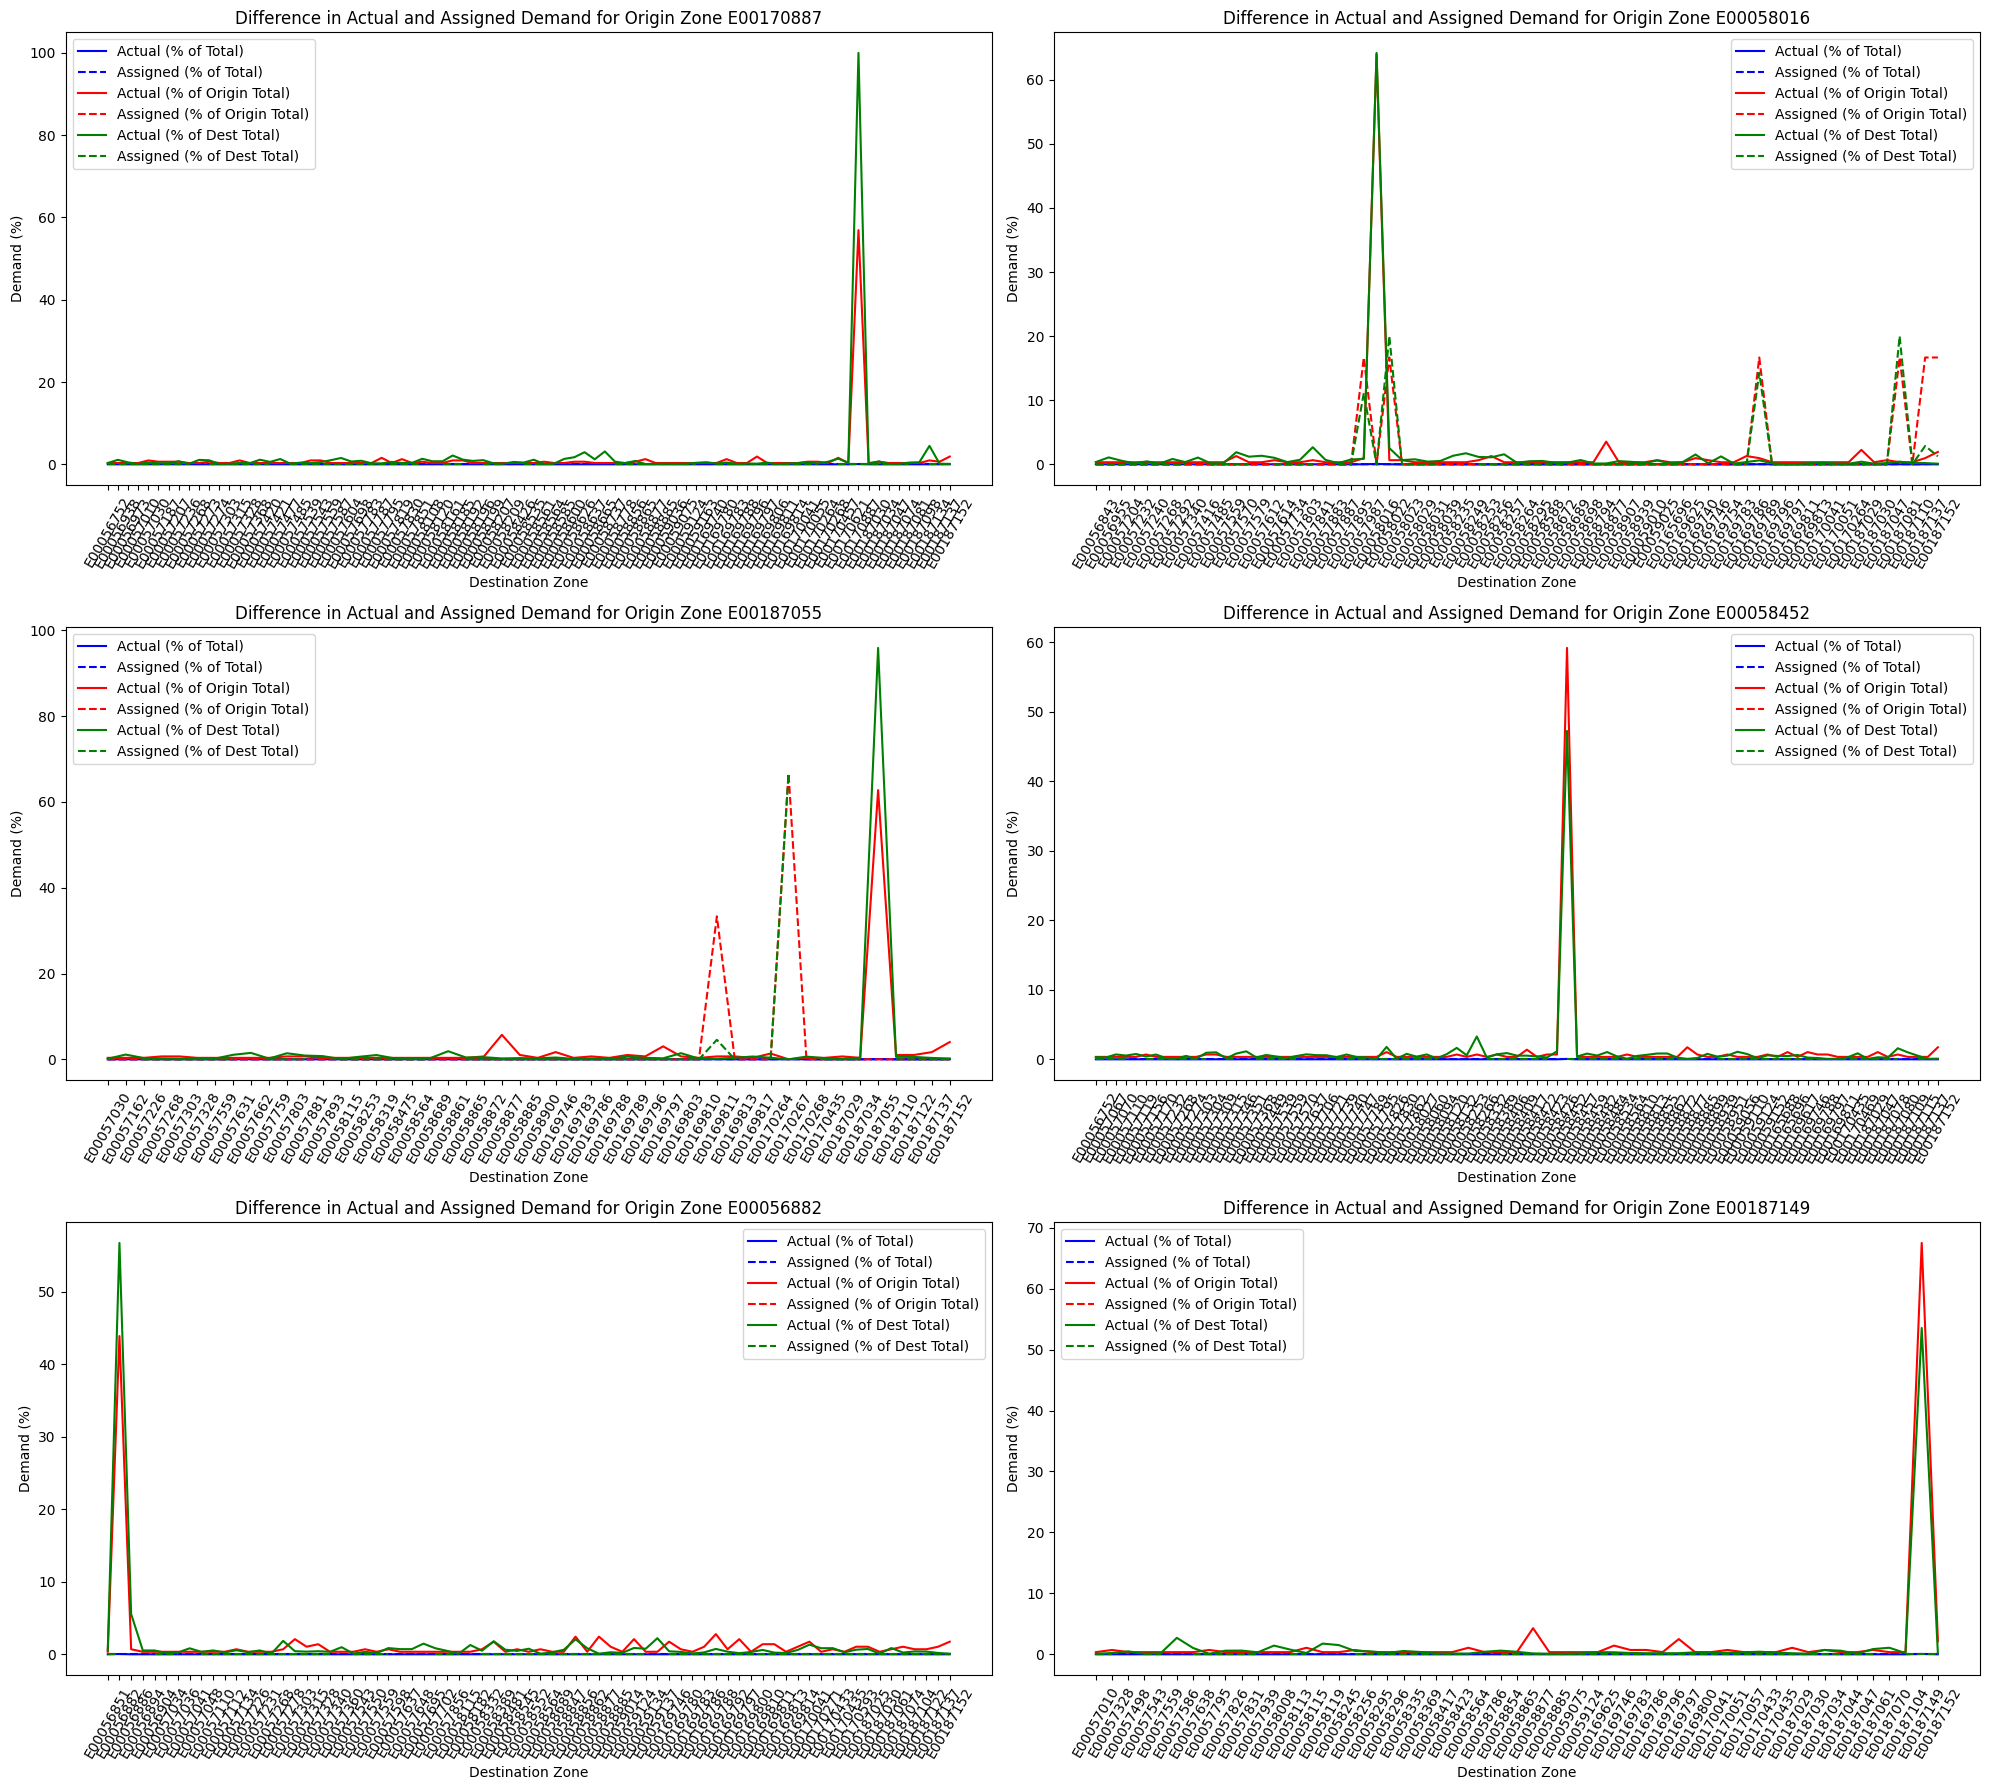

In [43]:
plot_workzone_assignment_line(
    workzone_assignment_opt,
    6,
    selection_type='top',
    sort_by='actual')

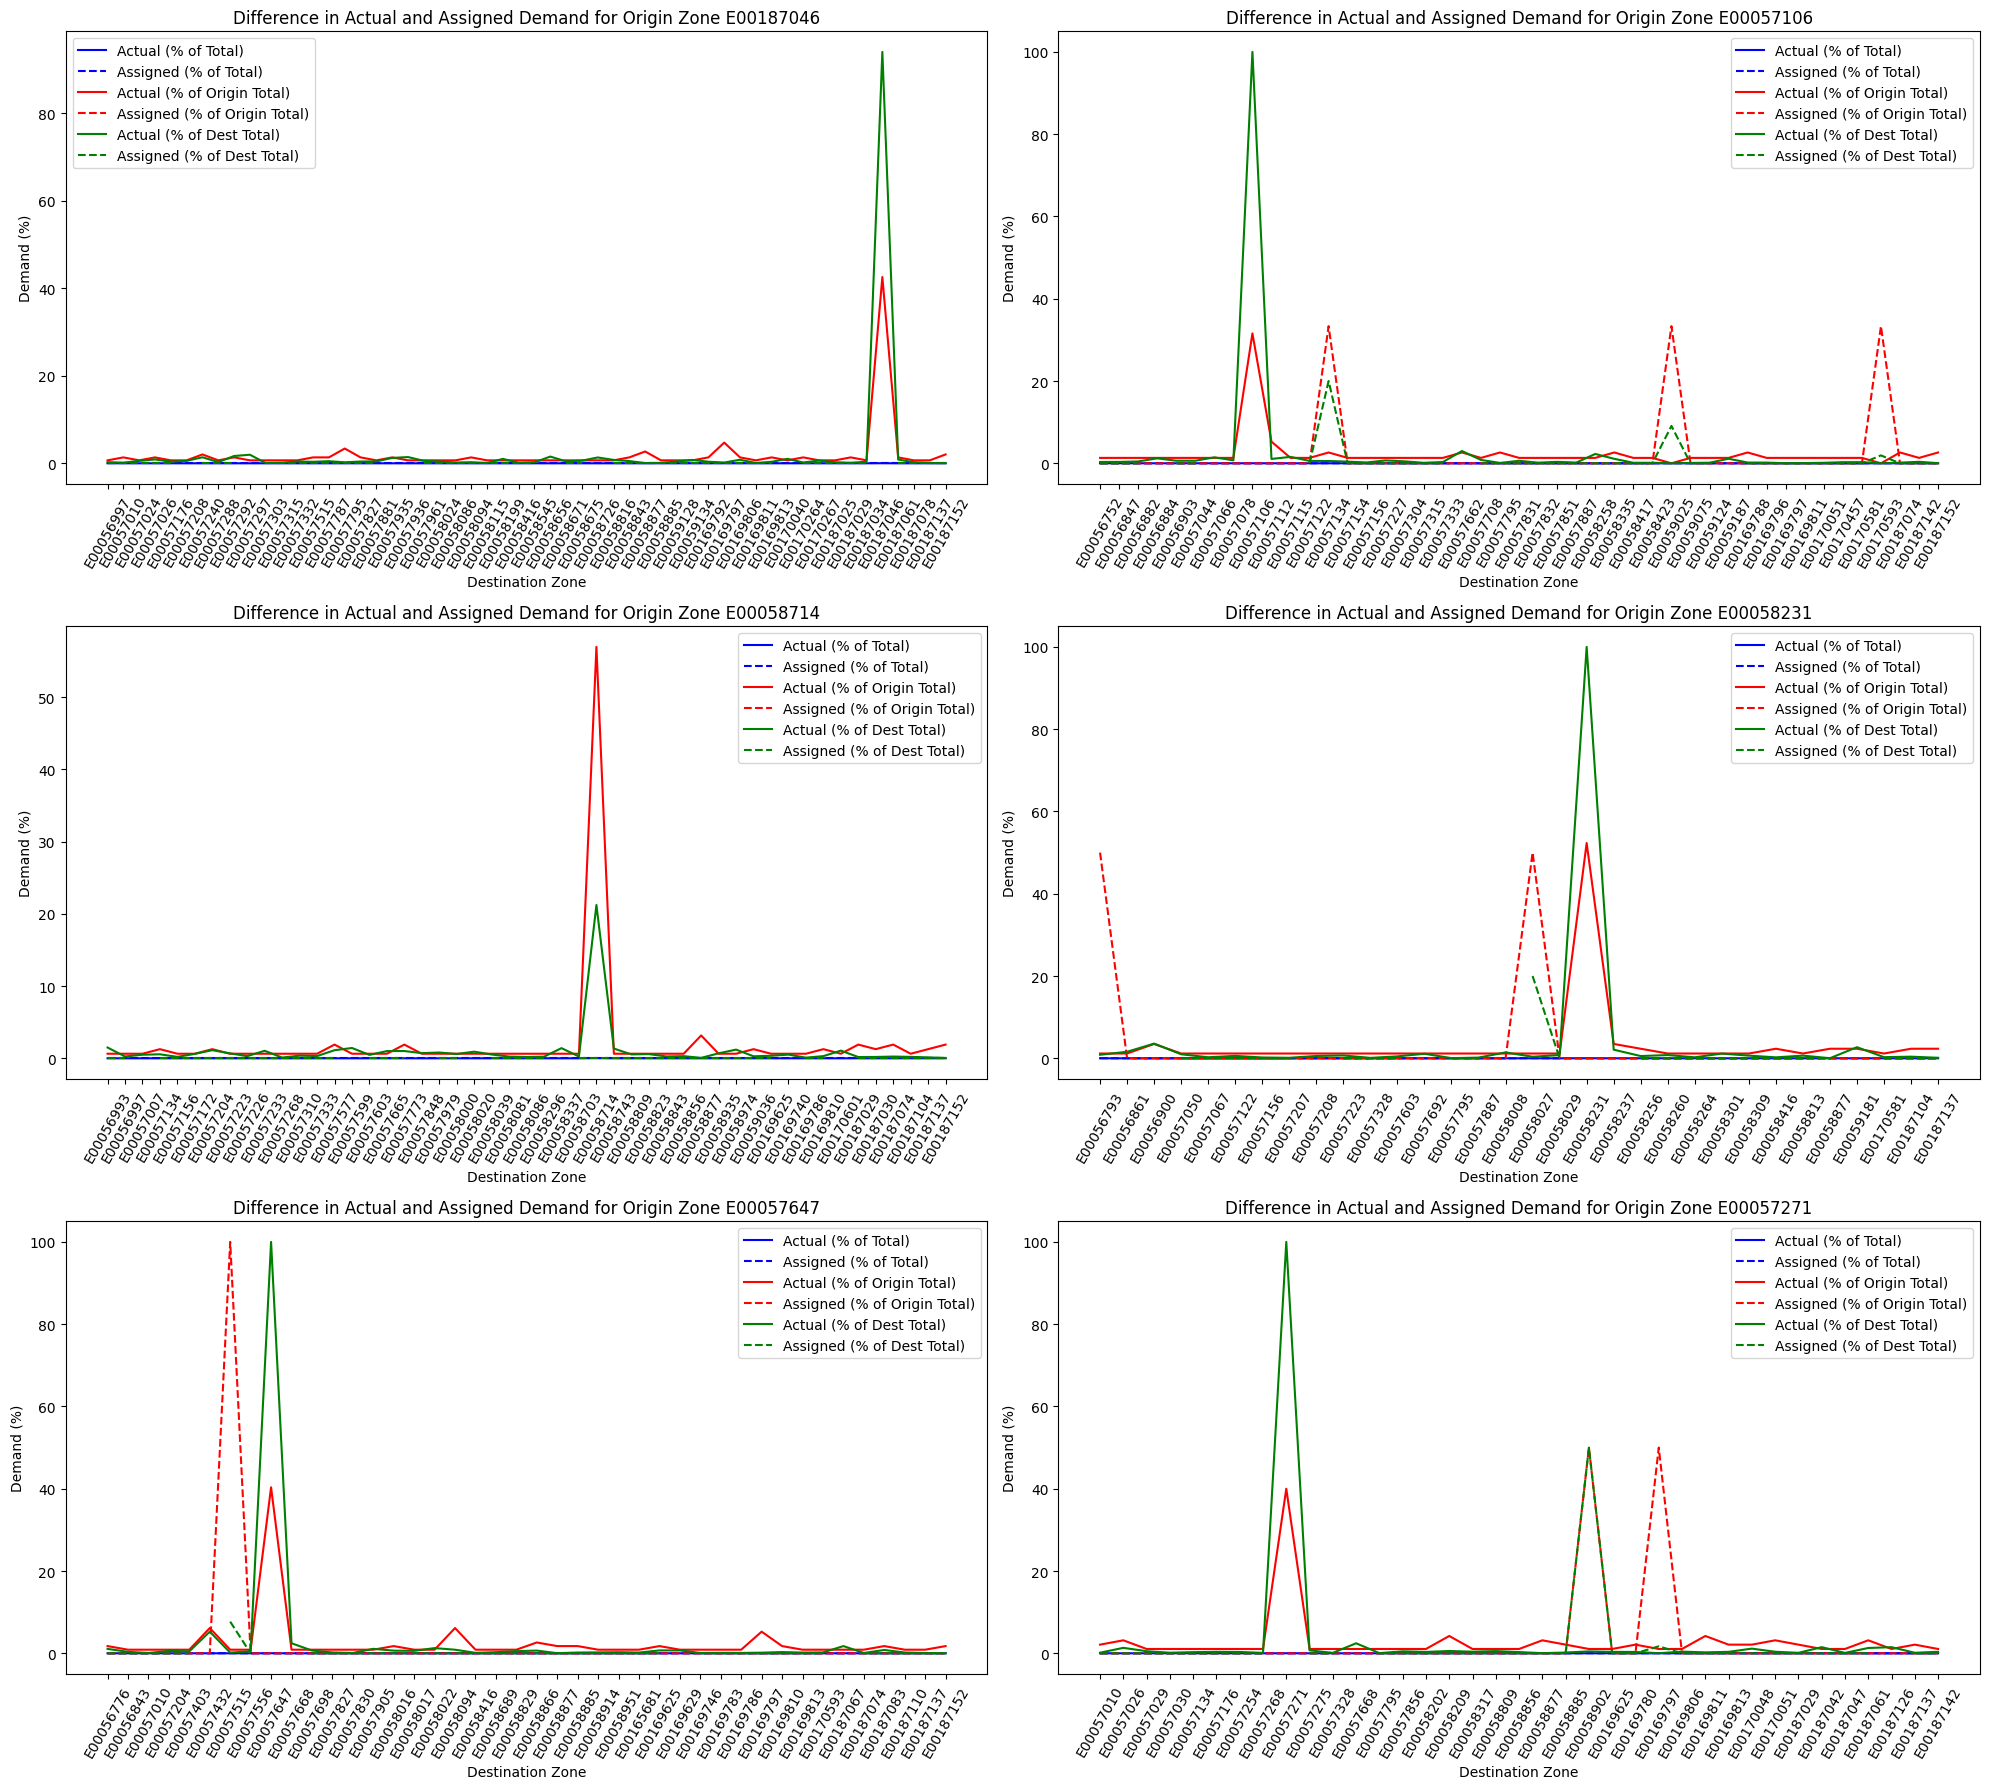

In [44]:
plot_workzone_assignment_line(workzone_assignment_opt, 6, selection_type='random', sort_by='actual')

##### Heatmaps

In [45]:
def plot_workzone_assignment_heatmap(
    assignment_results: pd.DataFrame,
    n: int,
    selection_type: str ='random',
    sort_by: str = 'assigned'
):

    """
    Create three heatmaps side by side showing the aggregated difference between actual and assigned demand percentages
    for the same n origin_zones across all categories (Global, Origin_Sum, Destination_Sum). The origin_zones are
    either randomly selected or the top n zones with the highest actual demand, consistent across all categories.

    Parameters
    ----------
    assignment_results : DataFrame
        DataFrame containing the actual and assigned demand values.
    n : int
        Number of unique origin_zones to include.
    selection_type : str
        Type of selection for origin_zones. Options: 'random', 'top'.
    sort_by : str
        Column to sort the origin_zones by when selecting the top n. Options: 'actual', 'assigned'
        'actual': Sort by the actual demand, 'assigned': Sort by the assigned

    Returns
    -------
    A matplotlib + seaborn plot.

    """
    categories = ['Global', 'Origin', 'Destination']
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

    # Select zones based on selection_type
    if selection_type == 'random':
        unique_zones = assignment_results['origin_zone'].unique()
        n = min(n, len(unique_zones))
        selected_zones = np.random.choice(unique_zones, size=n, replace=False)
    elif selection_type == 'top':
        # Sort
        top_zones_df = assignment_results.sort_values(by= f'demand_{sort_by}', ascending=False).drop_duplicates('origin_zone').head(n)
        selected_zones = top_zones_df['origin_zone'].values

    for i, category in enumerate(categories):
        prefix_map = {
            'Global': 'pct_of_total_demand',
            'Origin': 'pct_of_o_total',
            'Destination': 'pct_of_d_total'
        }
        prefix = prefix_map[category]

        filtered_df = assignment_results[assignment_results['origin_zone'].isin(selected_zones)].copy()
        filtered_df['difference'] = filtered_df[f'{prefix}_actual'] - filtered_df[f'{prefix}_assigned']
        heatmap_data = filtered_df.pivot_table(index="assigned_zone", columns="origin_zone", values="difference", aggfunc=np.mean)

        ax = sns.heatmap(heatmap_data, cmap='RdBu', ax=axes[i], cbar=i == len(categories) - 1)
        axes[i].set_title(f'Demand Difference: % of {category} Total')
        axes[i].set_xlabel('Home Zone')
        if i == 0:
            axes[i].set_ylabel('Assigned Zone')
        else:
            axes[i].set_ylabel('')

        if i == len(categories) - 1:
            # Create a colorbar with a vertical title
            cbar = ax.collections[0].colorbar
            cbar.ax.set_ylabel('Demand Difference: Actual (%) - Assigned (%)', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_199120/1239514932.py:53: FutureWarning: The provided callable <function mean at 0x7141f2d15990> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = filtered_df.pivot_table(index="assigned_zone", columns="origin_zone", values="difference", aggfunc=np.mean)
/tmp/ipykernel_199120/1239514932.py:53: FutureWarning: The provided callable <function mean at 0x7141f2d15990> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = filtered_df.pivot_table(index="assigned_zone", columns="origin_zone", values="difference", aggfunc=np.mean)
/tmp/ipykernel_199120/1239514932.py:53: FutureWarning: The provided callable <function mean at 0x7141f2d15990> is currently using DataFrameGroupBy.mean. In a future version of pa

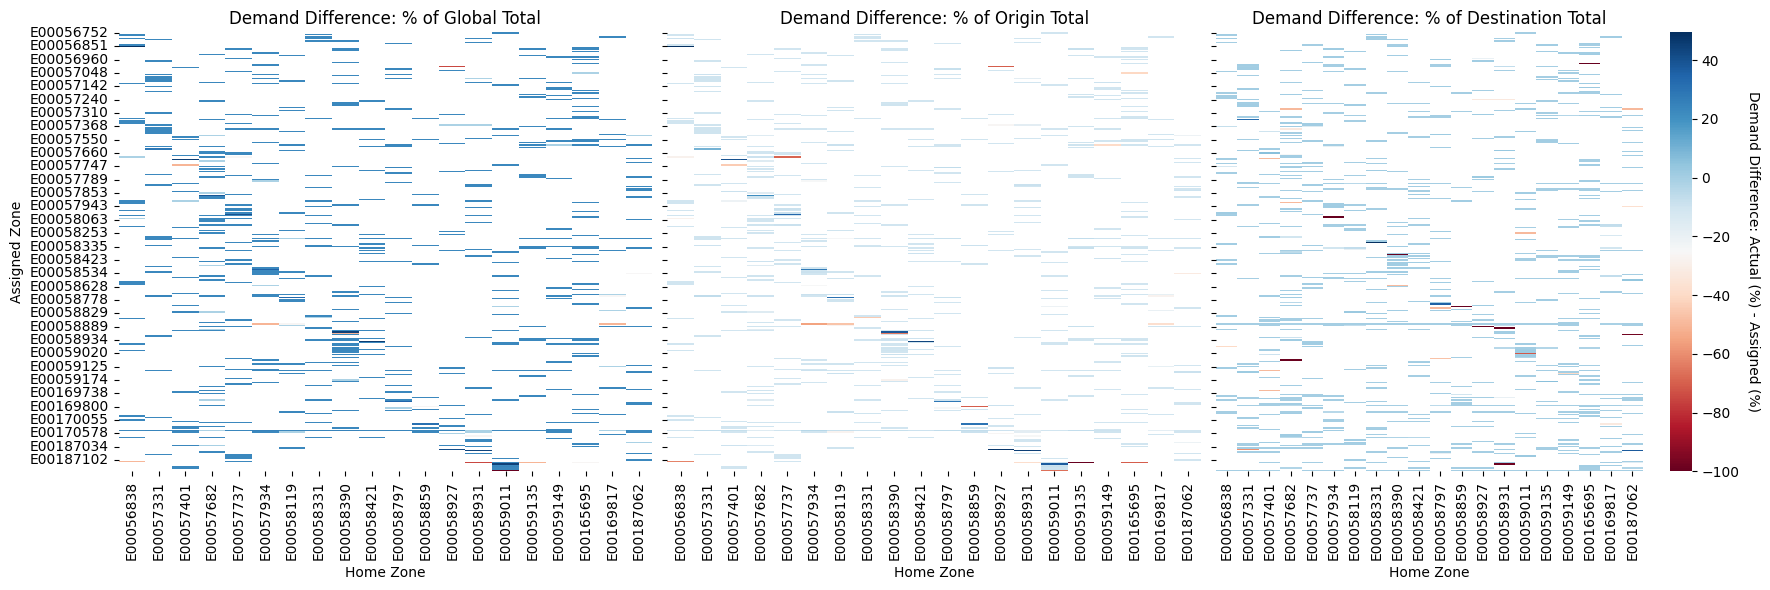

In [46]:
plot_workzone_assignment_heatmap(workzone_assignment_opt, n=20, selection_type='top', sort_by='assigned')

/tmp/ipykernel_199120/1239514932.py:53: FutureWarning: The provided callable <function mean at 0x7141f2d15990> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = filtered_df.pivot_table(index="assigned_zone", columns="origin_zone", values="difference", aggfunc=np.mean)
/tmp/ipykernel_199120/1239514932.py:53: FutureWarning: The provided callable <function mean at 0x7141f2d15990> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = filtered_df.pivot_table(index="assigned_zone", columns="origin_zone", values="difference", aggfunc=np.mean)
/tmp/ipykernel_199120/1239514932.py:53: FutureWarning: The provided callable <function mean at 0x7141f2d15990> is currently using DataFrameGroupBy.mean. In a future version of pa

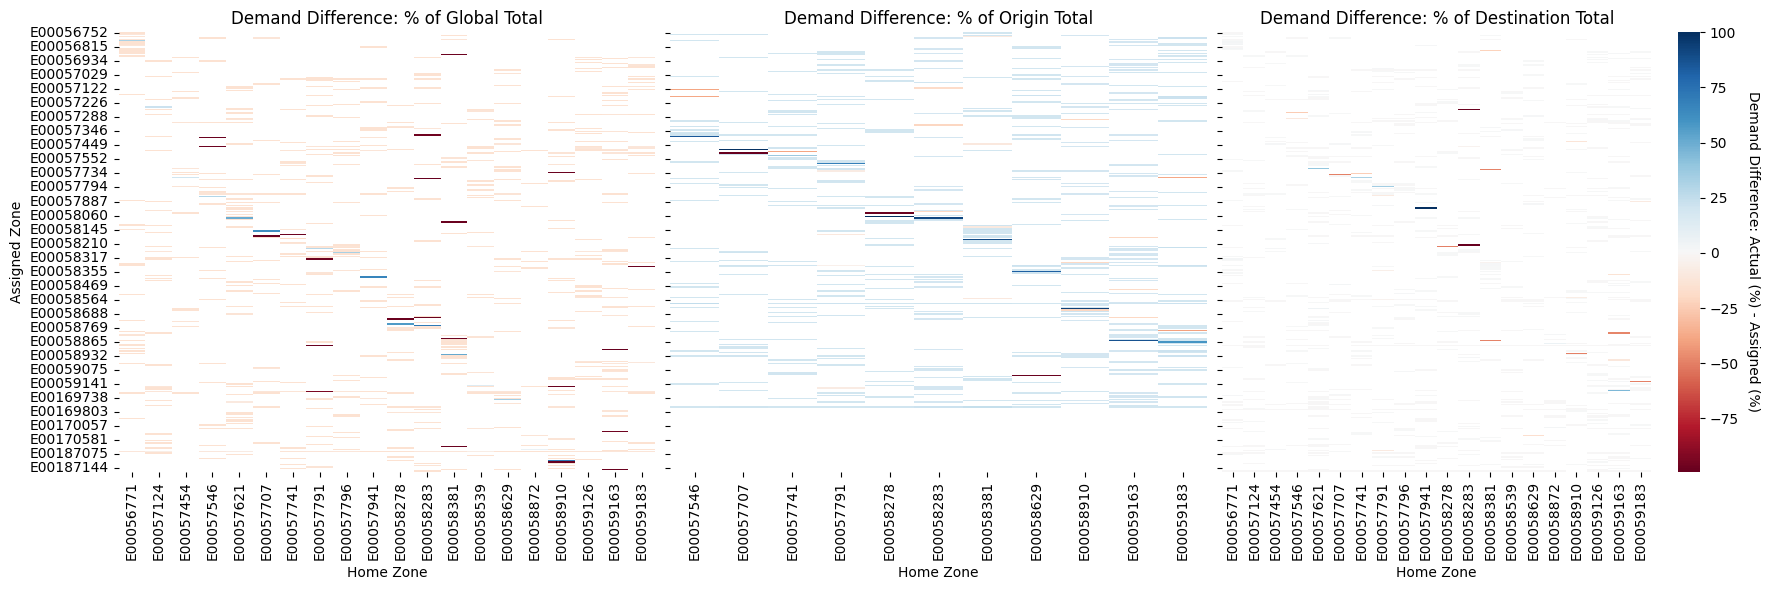

In [47]:
plot_workzone_assignment_heatmap(workzone_assignment_opt, n=20, selection_type='random')

##### Mapping the differences



$$q_{j} = (D_{j} - D_{j}^{obs}) / \sum_{i=1}^{k} D_{k} = (D{j} / \sum_{k} D_{k}) - (D{j}^{obs} / \sum_{k} D_{k}^{obs})$$ 

- $D_{j}$ is the number of trips going to zone $j$ in the synthetic data, and $D_{j}^{obs}$ is the number of trips going to zone $j$ in the observed data. 
- $D_{k}$ is the total number of trips in the synthetic data, and $D_{k}^{obs}$ is the total number of trips in the observed data.


In [48]:
total_actual = workzone_assignment_opt['demand_actual'].sum()
total_assigned = workzone_assignment_opt['demand_assigned'].sum()

# Calculate the total demand and total assigned demand for each destination zone
workzone_assignment_opt_agg = workzone_assignment_opt.groupby('assigned_zone').agg(
    total_demand_actual=('demand_actual', 'sum'),
    total_demand_assigned=('demand_assigned', 'sum')
).reset_index()

# Calculate qj (total_demand_actual / total_actual)
workzone_assignment_opt_agg['dj_actual_dk'] = workzone_assignment_opt_agg['total_demand_actual'] / total_actual
workzone_assignment_opt_agg['dj_assigned_dk'] = workzone_assignment_opt_agg['total_demand_assigned'] / total_assigned
workzone_assignment_opt_agg['qj'] = (workzone_assignment_opt_agg['dj_actual_dk'] - workzone_assignment_opt_agg['dj_assigned_dk']) * 100

# workzone_assignment_opt_agg['qj'] = (workzone_assignment_opt_agg['total_demand_actual'] / total_actual) - (workzone_assignment_opt_agg['total_demand_assigned'] / total_assigned)
workzone_assignment_opt_agg

assigned_zone  total_demand_actual  total_demand_assigned  dj_actual_dk  \
0        E00056750                 57.0                    0.0      0.000174   
1        E00056751                 97.0                    0.0      0.000297   
2        E00056752                315.0                    7.0      0.000964   
3        E00056753                496.0                   22.0      0.001517   
4        E00056754                 77.0                    0.0      0.000236   
...            ...                  ...                    ...           ...   
2602     E00187149                353.0                    4.0      0.001080   
2603     E00187150                163.0                    0.0      0.000499   
2604     E00187151                 52.0                    0.0      0.000159   
2605     E00187152               6193.0                   80.0      0.018943   
2606     E00187153                 82.0                    0.0      0.000251   

      dj_assigned_dk        qj  
0           0.000000  0.017435  
1           0.000000  0.029671  
2           0.001942 -0.097875  
3           0.006104 -0.458714  
4           0.000000  0.023553  
...              ...       ...  
2602        0.001110 -0.003011  
2603        0.000000  0.049859  
2604        0.000000  0.015906  
2605        0.022198 -0.325414  
2606        0.000000  0.025083  

[2607 rows x 6 columns]

In [49]:
total_actual, total_assigned

(326921.0, 3604.0)

Add boundary layer to plot

In [50]:
# merge boundaries with workzone_assignment_opt
workzone_assignment_opt_agg_gdf = boundaries[['OA21CD', 'geometry']].merge(workzone_assignment_opt_agg, left_on='OA21CD', right_on='assigned_zone', how='left')

# Ensure the result is a GeoDataFrame
workzone_assignment_opt_agg_gdf = gpd.GeoDataFrame(workzone_assignment_opt_agg_gdf)
workzone_assignment_opt_agg_gdf

OA21CD                                           geometry  \
0     E00056750  MULTIPOLYGON (((-1.68707 53.86899, -1.68739 53...   
1     E00056751  MULTIPOLYGON (((-1.70054 53.86612, -1.70059 53...   
2     E00056752  MULTIPOLYGON (((-1.69350 53.86903, -1.69372 53...   
3     E00056753  MULTIPOLYGON (((-1.68012 53.86746, -1.68025 53...   
4     E00056754  MULTIPOLYGON (((-1.67749 53.86494, -1.67754 53...   
...         ...                                                ...   
2602  E00187149  MULTIPOLYGON (((-1.51430 53.77917, -1.51620 53...   
2603  E00187150  MULTIPOLYGON (((-1.39649 53.74616, -1.39795 53...   
2604  E00187151  MULTIPOLYGON (((-1.73359 53.88326, -1.73432 53...   
2605  E00187152  MULTIPOLYGON (((-1.54870 53.80293, -1.54932 53...   
2606  E00187153  MULTIPOLYGON (((-1.52832 53.79507, -1.52842 53...   

     assigned_zone  total_demand_actual  total_demand_assigned  dj_actual_dk  \
0        E00056750                 57.0                    0.0      0.000174   
1        E00056751                 97.0                    0.0      0.000297   
2        E00056752                315.0                    7.0      0.000964   
3        E00056753                496.0                   22.0      0.001517   
4        E00056754                 77.0                    0.0      0.000236   
...            ...                  ...                    ...           ...   
2602     E00187149                353.0                    4.0      0.001080   
2603     E00187150                163.0                    0.0      0.000499   
2604     E00187151                 52.0                    0.0      0.000159   
2605     E00187152               6193.0                   80.0      0.018943   
2606     E00187153                 82.0                    0.0      0.000251   

      dj_assigned_dk        qj  
0           0.000000  0.017435  
1           0.000000  0.029671  
2           0.001942 -0.097875  
3           0.006104 -0.458714  
4           0.000000  0.023553  
...              ...       ...  
2602        0.001110 -0.003011  
2603        0.000000  0.049859  
2604        0.000000  0.015906  
2605        0.022198 -0.325414  
2606        0.000000  0.025083  

[2607 rows x 8 columns]

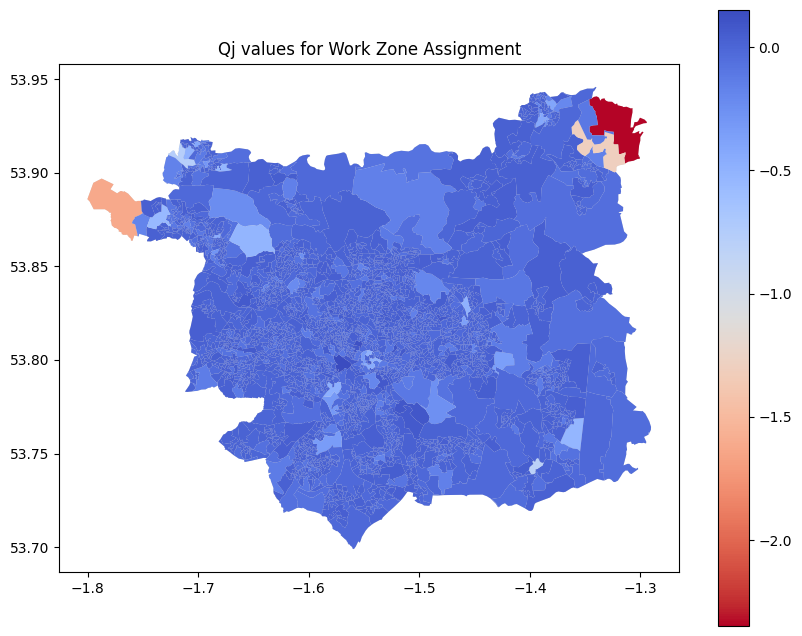

In [51]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
boundaries.plot(ax=ax, color='lightgrey')
workzone_assignment_opt_agg_gdf.plot(column='qj', legend=True, cmap='coolwarm_r', ax=ax)

plt.title('Qj values for Work Zone Assignment')
plt.show()


#### Add zones to the activity chains


In [52]:
# "assigned_zone" from workzone_assignment_opt should replace "dzone" in activity_chains_work
activity_chains_work = activity_chains_work.merge(workzone_assignment_opt[['origin_zone', 'assigned_zone']], left_on='OA21CD', right_on='origin_zone', how='left')

# drop origin_zone column
activity_chains_work = activity_chains_work.drop(columns='origin_zone')
# drop original dzone column
activity_chains_work = activity_chains_work.drop(columns='dzone')
# rename assigned_zone to dzone
activity_chains_work = activity_chains_work.rename(columns={'assigned_zone': 'dzone'})


In [53]:
activity_chains_work.head(5)

id  household                   location   pid_hs       msoa  \
0  1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
1  1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
2  1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
3  1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
4  1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   

          oa             members sic1d2007  sic2d2007  pwkstat  salary_yearly  \
0  E00059011  [1193224, 1193225]         C       25.0        6            NaN   
1  E00059011  [1193224, 1193225]         C       25.0        6            NaN   
2  E00059011  [1193224, 1193225]         C       25.0        6            NaN   
3  E00059011  [1193224, 1193225]         C       25.0        6            NaN   
4  E00059011  [1193224, 1193225]         C       25.0        6            NaN   

   salary_hourly             hid  accommodation_type  communal_type  \
0            NaN  E02002330_0109                 1.0            NaN   
1            NaN  E02002330_0109                 1.0            NaN   
2            NaN  E02002330_0109                 1.0            NaN   
3            NaN  E02002330_0109                 1.0            NaN   
4            NaN  E02002330_0109                 1.0            NaN   

   num_rooms  central_heat  tenure  num_cars  sex  age_years  ethnicity  \
0        6.0          True     1.0         1    1         71          1   
1        6.0          True     1.0         1    1         71          1   
2        6.0          True     1.0         1    1         71          1   
3        6.0          True     1.0         1    1         71          1   
4        6.0          True     1.0         1    1         71          1   

   nssec8  salary_yearly_hh  salary_yearly_hh_cat  is_adult  num_adults  \
0     4.0               0.0                     1         1           1   
1     4.0               0.0                     1         1           1   
2     4.0               0.0                     1         1           1   
3     4.0               0.0                     1         1           1   
4     4.0               0.0                     1         1           1   

   is_child  num_children  is_pension_age  num_pension_age  pwkstat_FT_hh  \
0         0             1               1                1              0   
1         0             1               1                1              0   
2         0             1               1                1              0   
3         0             1               1                1              0   
4         0             1               1                1              0   

   pwkstat_PT_hh  pwkstat_NTS_match     OA11CD                RUC11 RUC11CD  \
0              0                  1  E00059011  Urban city and town      C1   
1              0                  1  E00059011  Urban city and town      C1   
2              0                  1  E00059011  Urban city and town      C1   
3              0                  1  E00059011  Urban city and town      C1   
4              0                  1  E00059011  Urban city and town      C1   

  Settlement2011EW_B03ID_spc Settlement2011EW_B04ID_spc  \
0                      Urban        Urban City and Town   
1                      Urban        Urban City and Town   
2                      Urban        Urban City and Town   
3                      Urban        Urban City and Town   
4                      Urban        Urban City and Town   

   Settlement2011EW_B03ID_spc_CD  Settlement2011EW_B04ID_spc_CD  \
0                              1                              2   
1                              1                              2   
2                              1                              2   
3                              1                              2   
4                              1                              2   

   tenure_spc_for_matching       nts_hh_id  age_group  nts_ind_

 ### Assign activity to point locations

After choosing a zone, let's assign the activity to a point location. 

#### 1. Get neighboring zones

Sometimes, an activity can be assigned to a zone, but there are no facilities in the zone that match the activity type. In this case, we can search for matching facilities in neighboring zones.

In [54]:

# Assuming zones_gdf is your GeoDataFrame containing the zones
zone_neighbors = Queen.from_dataframe(boundaries, idVariable='OA21CD').neighbors

zone_neighbors

/tmp/ipykernel_199120/4278911732.py:2: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  zone_neighbors = Queen.from_dataframe(boundaries, idVariable='OA21CD').neighbors


{'E00056750': ['E00056805',
  'E00056771',
  'E00056816',
  'E00056790',
  'E00056795',
  'E00056809',
  'E00056755',
  'E00056819',
  'E00056796',
  'E00056752'],
 'E00056751': ['E00056820',
  'E00056808',
  'E00056815',
  'E00056822',
  'E00056831',
  'E00056800'],
 'E00056752': ['E00056805',
  'E00056820',
  'E00056750',
  'E00056815',
  'E00056821',
  'E00056755',
  'E00056796',
  'E00056818'],
 'E00056753': ['E00056812',
  'E00056754',
  'E00056825',
  'E00056816',
  'E00056819'],
 'E00056754': ['E00056812',
  'E00058305',
  'E00056825',
  'E00056823',
  'E00056753',
  'E00058317'],
 'E00056755': ['E00056757',
  'E00056750',
  'E00056756',
  'E00056830',
  'E00056821',
  'E00056832',
  'E00056819',
  'E00056828',
  'E00056752'],
 'E00056756': ['E00056819',
  'E00056825',
  'E00056823',
  'E00056755',
  'E00056830'],
 'E00056757': ['E00056832',
  'E00056836',
  'E00056823',
  'E00056755',
  'E00056835',
  'E00056760',
  'E00056830'],
 'E00056758': ['E00056821',
  'E00056834',
  'E0

#### 2. Select a facility


In [55]:
from typing import Optional


def select_facility(row: pd.Series,
                    facilities_gdf: gpd.GeoDataFrame,
                    row_destination_zone_col: str,
                    gdf_facility_zone_col: str,
                    row_activity_type_col: str,
                    gdf_facility_type_col: str,
                    fallback_type: Optional[str] = None,
                    neighboring_zones: Optional[dict] = None,
                    gdf_sample_col: Optional[str] = None) -> pd.Series:
    """
    Select a suitable facility based on the activity type and a specific zone from a GeoDataFrame. 
    Optionally:
     - looks in neighboring zones when there is no suitable facility in the initial zone
     - add a fallback type to search for a more general type of facility when no specific facilities are found
       (e.g. 'education' instead of 'education_university')
     - sample based on a specific column in the GeoDataFrame (e..g. floor_area)

    Parameters
    ----------
    selection_row : pandas.Series
        A row from the DataFrame indicating the selection criteria, including the destination zone and activity type.
    facilities_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing facilities to sample from.
    row_destination_zone_col : str
        The column name in `selection_row` that indicates the destination zone.
    gdf_facility_zone_col : str
        The column name in `facilities_gdf` that indicates the facility zone.
    row_activity_type_col : str
        The column in `selection_row` indicating the type of activity (e.g., 'education', 'work').
    gdf_facility_type_col : str
        The column in `facilities_gdf` to filter facilities by type based on the activity type.
    fallback_type : Optional[str]
        A more general type of facility to fallback to if no specific facilities are found. By default None.
    neighboring_zones : Optional[dict]
        A dictionary mapping zones to their neighboring zones for fallback searches, by default None.
    gdf_sample_col : Optional[str]
        The column to sample from, by default None. The only feasible input is "floor_area". If "floor_area" is specified,
        uses this column's values as weights for sampling.

    Returns
    -------
    pd.Series
        Series containing the id and geometry of the chosen facility. Returns NaN if no suitable facility is found.
    """
    # Extract the destination zone from the input row
    destination_zone = row[row_destination_zone_col]
    if pd.isna(destination_zone):
        logging.info(f"Destination zone is NA for row {row.name}")
        return pd.Series([np.nan, np.nan])

    # Filter facilities within the specified destination zone
    facilities_in_zone = facilities_gdf[facilities_gdf[gdf_facility_zone_col] == destination_zone]
    # Attempt to find facilities matching the specific facility type
    facilities_valid = facilities_in_zone[facilities_in_zone[gdf_facility_type_col].apply(lambda x: row[row_activity_type_col] in x)]

    # If no specific facilities found in the initial zone, and neighboring zones are provided, search in neighboring zones
    if facilities_valid.empty and neighboring_zones:
        logging.info(f"No {row[row_activity_type_col]} facilities in {destination_zone}. Expanding search to neighboring zones")
        neighbors = neighboring_zones.get(destination_zone, [])
        facilities_in_neighboring_zones = facilities_gdf[facilities_gdf[gdf_facility_zone_col].isin(neighbors)]
        facilities_valid = facilities_in_neighboring_zones[facilities_in_neighboring_zones[gdf_facility_type_col].apply(lambda x: row[row_activity_type_col] in x)]
        logging.info(f"Found {len(facilities_valid)} matching facilities in neighboring zones")

    # If no specific facilities found and a fallback type is provided, attempt to find facilities matching the fallback type
    if facilities_valid.empty and fallback_type:
        logging.info(f"No {row[row_activity_type_col]} facilities in zone {destination_zone} or neighboring zones, trying with {fallback_type}")
        # This should consider both the initial zone and neighboring zones if the previous step expanded the search
        facilities_valid = facilities_in_zone[facilities_in_zone[gdf_facility_type_col].apply(lambda x: fallback_type in x)]
        logging.info(f"Found {len(facilities_valid)} matching facilities with type: {fallback_type}")

    # If no facilities found after all attempts, log the failure and return NaN
    if facilities_valid.empty:
        logging.info(f"No facilities in zone {destination_zone} with {gdf_facility_type_col} '{fallback_type or row[row_activity_type_col]}'")
        return pd.Series([np.nan, np.nan])

    # If "floor_area" is specified for sampling
    if gdf_sample_col == "floor_area" and "floor_area" in facilities_valid.columns and facilities_valid["floor_area"].sum() != 0:
        facility = facilities_valid.sample(1, weights=facilities_valid["floor_area"])
    else:
        # Otherwise, randomly sample one facility from the valid facilities
        facility = facilities_valid.sample(1)

    # Return the id and geometry of the selected facility
    return pd.Series([facility['id'].values[0], facility['geometry'].values[0]])

In [56]:
activity_chains_ex = activity_chains_work.copy()
# apply the function to a row in activity_chains_ex
activity_chains_ex[['activity_id', 'activity_geom']] = activity_chains_ex.apply(lambda row: select_facility(
    row = row,
    facilities_gdf = osm_data_gdf,
    row_destination_zone_col = 'dzone',
    row_activity_type_col =  'dact',
    gdf_facility_zone_col = 'OA21CD',
    gdf_facility_type_col = 'activities',
    gdf_sample_col = 'floor_area',
    neighboring_zones = zone_neighbors),
axis=1)

activity_chains_ex.tail(5)

id  household                   location   pid_hs       msoa  \
155534  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155535  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155536  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155537  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155538  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   

               oa                      members sic1d2007  sic2d2007  pwkstat  \
155534  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155535  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155536  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155537  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155538  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   

        salary_yearly  salary_hourly             hid  accommodation_type  \
155534            NaN            NaN  E02006876_3513                 3.0   
155535            NaN            NaN  E02006876_3513                 3.0   
155536            NaN            NaN  E02006876_3513                 3.0   
155537            NaN            NaN  E02006876_3513                 3.0   
155538            NaN            NaN  E02006876_3513                 3.0   

        communal_type  num_rooms  central_heat  tenure  num_cars  sex  \
155534            NaN        4.0          True     2.0         2    1   
155535            NaN        4.0          True     2.0         2    1   
155536            NaN        4.0          True     2.0         2    1   
155537            NaN        4.0          True     2.0         2    1   
155538            NaN        4.0          True     2.0         2    1   

        age_years  ethnicity  nssec8  salary_yearly_hh  salary_yearly_hh_cat  \
155534         40          1     2.0      24607.511719                     1   
155535         40          1     2.0      24607.511719                     1   
155536         40          1     2.0      24607.511719                     1   
155537         40          1     2.0      24607.511719                     1   
155538         40          1     2.0      24607.511719                     1   

        is_adult  num_adults  is_child  num_children  is_pension_age  \
155534         1           2         0             1               0   
155535         1           2         0             1               0   
155536         1           2         0             1               0   
155537         1           2         0             1               0   
155538         1           2         0             1               0   

        num_pension_age  pwkstat_FT_hh  pwkstat_PT_hh  pwkstat_NTS_match  \
155534                0              1              0                  3   
155535                0              1              0                  3   
155536                0              1              0                  3   
155537                0              1              0                  3   
155538                0              1              0                  3   

           OA11CD                    RUC11 RUC11CD Settlement2011EW_B03ID_spc  \
155534  E00057799  Urban major conurbation      A1                      Urban   
155535  E00057799  Urban major conurbation      A1                      Urban   
155536  E00057799  Urban major conurbation      A1                      Urban   
155537  E00057799  Urban major conurbation      A1                      Urban   
155538  E00057799  Urban major conurbation      A1                      Urban   

       Settlement2011EW_B04ID_spc  Settlement2011EW_B03ID_spc_CD  \
155534          Urban Conurbation                              1   
155535          Urban Conurbation                              1   
155536          Urban Conurbation                              1   
155537          Urban Conurbation          

In [57]:
# For each row in activity_chains_ex, turn the geometry into a linestring: Origin = location and destination = activity_geom
from shapely.geometry import LineString

activity_chains_plot = activity_chains_ex.copy()
# filter to only include rows where activity_geom is not NA
activity_chains_plot = activity_chains_plot[activity_chains_plot['activity_geom'].notna()]
activity_chains_plot['line_geometry'] = activity_chains_plot.apply(lambda row: LineString([row['location'], row['activity_geom']]), axis=1)
# Set the geometry column to 'line_geometry'
activity_chains_plot = activity_chains_plot.set_geometry('line_geometry')

# add the original crs
activity_chains_plot.crs = "EPSG:4326"

# convert crs to metric
activity_chains_plot = activity_chains_plot.to_crs(epsg=3857)
# calculate the length of the line_geometry in meters
activity_chains_plot['length'] = activity_chains_plot['line_geometry'].length

activity_chains_plot.head(10)

# convert crs back to 4326
activity_chains_plot = activity_chains_plot.to_crs(epsg=4326)

In [58]:
activity_chains_plot

id  household                   location   pid_hs       msoa  \
0       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
1       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
2       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
3       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
4       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
...         ...        ...                        ...      ...        ...   
155534  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155535  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155536  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155537  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
155538  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   

               oa                      members sic1d2007  sic2d2007  pwkstat  \
0       E00059011           [1193224, 1193225]         C       25.0        6   
1       E00059011           [1193224, 1193225]         C       25.0        6   
2       E00059011           [1193224, 1193225]         C       25.0        6   
3       E00059011           [1193224, 1193225]         C       25.0        6   
4       E00059011           [1193224, 1193225]         C       25.0        6   
...           ...                          ...       ...        ...      ...   
155534  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155535  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155536  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155537  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
155538  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   

        salary_yearly  salary_hourly             hid  accommodation_type  \
0                 NaN            NaN  E02002330_0109                 1.0   
1                 NaN            NaN  E02002330_0109                 1.0   
2                 NaN            NaN  E02002330_0109                 1.0   
3                 NaN            NaN  E02002330_0109                 1.0   
4                 NaN            NaN  E02002330_0109                 1.0   
...               ...            ...             ...                 ...   
155534            NaN            NaN  E02006876_3513                 3.0   
155535            NaN            NaN  E02006876_3513                 3.0   
155536            NaN            NaN  E02006876_3513                 3.0   
155537            NaN            NaN  E02006876_3513                 3.0   
155538            NaN            NaN  E02006876_3513                 3.0   

        communal_type  num_rooms  central_heat  tenure  num_cars  sex  \
0                 NaN        6.0          True     1.0         1    1   
1                 NaN        6.0          True     1.0         1    1   
2                 NaN        6.0          True     1.0         1    1   
3                 NaN        6.0          True     1.0         1    1   
4                 NaN        6.0          True     1.0         1    1   
...               ...        ...           ...     ...       ...  ...   
155534            NaN        4.0          True     2.0         2    1   
155535            NaN        4.0          True     2.0         2    1   
155536            NaN        4.0          True     2.0         2    1   
155537            NaN        4.0          True     2.0         2    1   
155538            NaN        4.0          True     2.0         2    1   

        age_years  ethnicity  nssec8  salary_yearly_hh  salary_yearly_hh_cat  \
0              71          1     4.0          0.000000                     1   
1              71          1     4.0          0.000000                     1   
2              71          1     4.0          0.000000                     1   
3              71

##### Maps

In [154]:
import math

import matplotlib.patches as mpatches


def plot_activity_chains(activities: pd.DataFrame,
                         activity_type_col: str,
                         activity_type: str,
                         bin_size: int,
                         boundaries: gpd.GeoDataFrame,
                         sample_size: Optional[int] = None) -> None:
    """
    Plots activity chains for a given activity type, bin size, geographical boundaries, and an optional sample size.

    Parameters:
    activities: pd.DataFrame
        A DataFrame containing the activities data. Geometry is a LineString.
    activity_type_col: str
        The column name containing the activity type.
    activity_type: str
        The type of activity to plot.
    bin_size: int
        The size of the bins for the histogram. (in meters)
    boundaries: gpd.GeoDataFrame 
        A GeoDataFrame containing the geographical boundaries for the plot.
    sample_size: int, optional
        The size of the sample to plot. If None, all data is plotted.

    Returns:
        None    
    """
    activities_subset = activities[activities[activity_type_col] == activity_type]

    # If a sample size is specified, sample the activities
    if sample_size is not None and sample_size < len(activities_subset):
        activities_subset = activities_subset.sample(n=sample_size)

    # Mode legend
    modes = activities_subset['mode'].unique()  # Collect all unique modes
    colormap = plt.colormaps.get_cmap('Dark2')  # Generate a colormap
    mode_colors = {mode: colormap(i) for i, mode in enumerate(modes)}  # Map modes to colors
    legend_patches = [mpatches.Patch(color=mode_colors[mode], label=mode) for mode in modes]  # Create legend handles


    # Calculate the number of bins based on the maximum value of 'length'
    num_bins = math.ceil(activities_subset['length'].max() / bin_size)
    # Calculate the bin edges
    bins = np.arange(num_bins + 1) * bin_size
    # Create a new column 'length_band' by cutting 'length' into distance bands
    activities_subset['length_band'] = pd.cut(activities_subset['length'], bins, include_lowest=True)
    # Get unique bands and sort them
    bands = activities_subset['length_band'].unique()
    bands = sorted(bands, key=lambda x: x.left)
    # Calculate the total number of trips
    total_trips = len(activities_subset)

    # Calculate the number of rows and columns for the subplots
    nrows = math.ceil(len(bands) / 3)
    ncols = 3
    # Create a grid of subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 6 * nrows))
    # Flatten axs for easy iteration
    axs = axs.flatten()

    for ax, band in zip(axs, bands):
        # Get the subset for this band
        subset_band = activities_subset[activities_subset['length_band'] == band]

        # Calculate the percentage of trips in this band
        percentage = len(subset_band) / total_trips * 100

        # Plot the boundaries
        boundaries.plot(ax=ax, color='lightgrey')

         # Plot the subset with correct colors
        for mode in modes:
            # check if mode is in subset_band, and plot if it is
            if mode in subset_band['mode'].unique():
                subset_mode = subset_band[subset_band['mode'] == mode]
                subset_mode.plot(ax=ax, color=mode_colors[mode], label=mode)

        # Set the title
        ax.set_title(f'{activity_type},\ndistance band: {band},\nNo. of trips: {len(subset_band)} ({percentage:.2f}%)')

    # Remove any unused subplots
    for i in range(len(bands), nrows*ncols):
        fig.delaxes(axs[i])

    # Place the legend at the bottom
    plt.figlegend(handles=legend_patches, loc='lower center', ncol=5, title="Transportation Modes")  # Adjust 'ncol' as needed


    plt.tight_layout()
    plt.subplots_adjust(bottom=0.03, wspace = 0.1, hspace= 0.2)  # Adjust space to show the legend properly

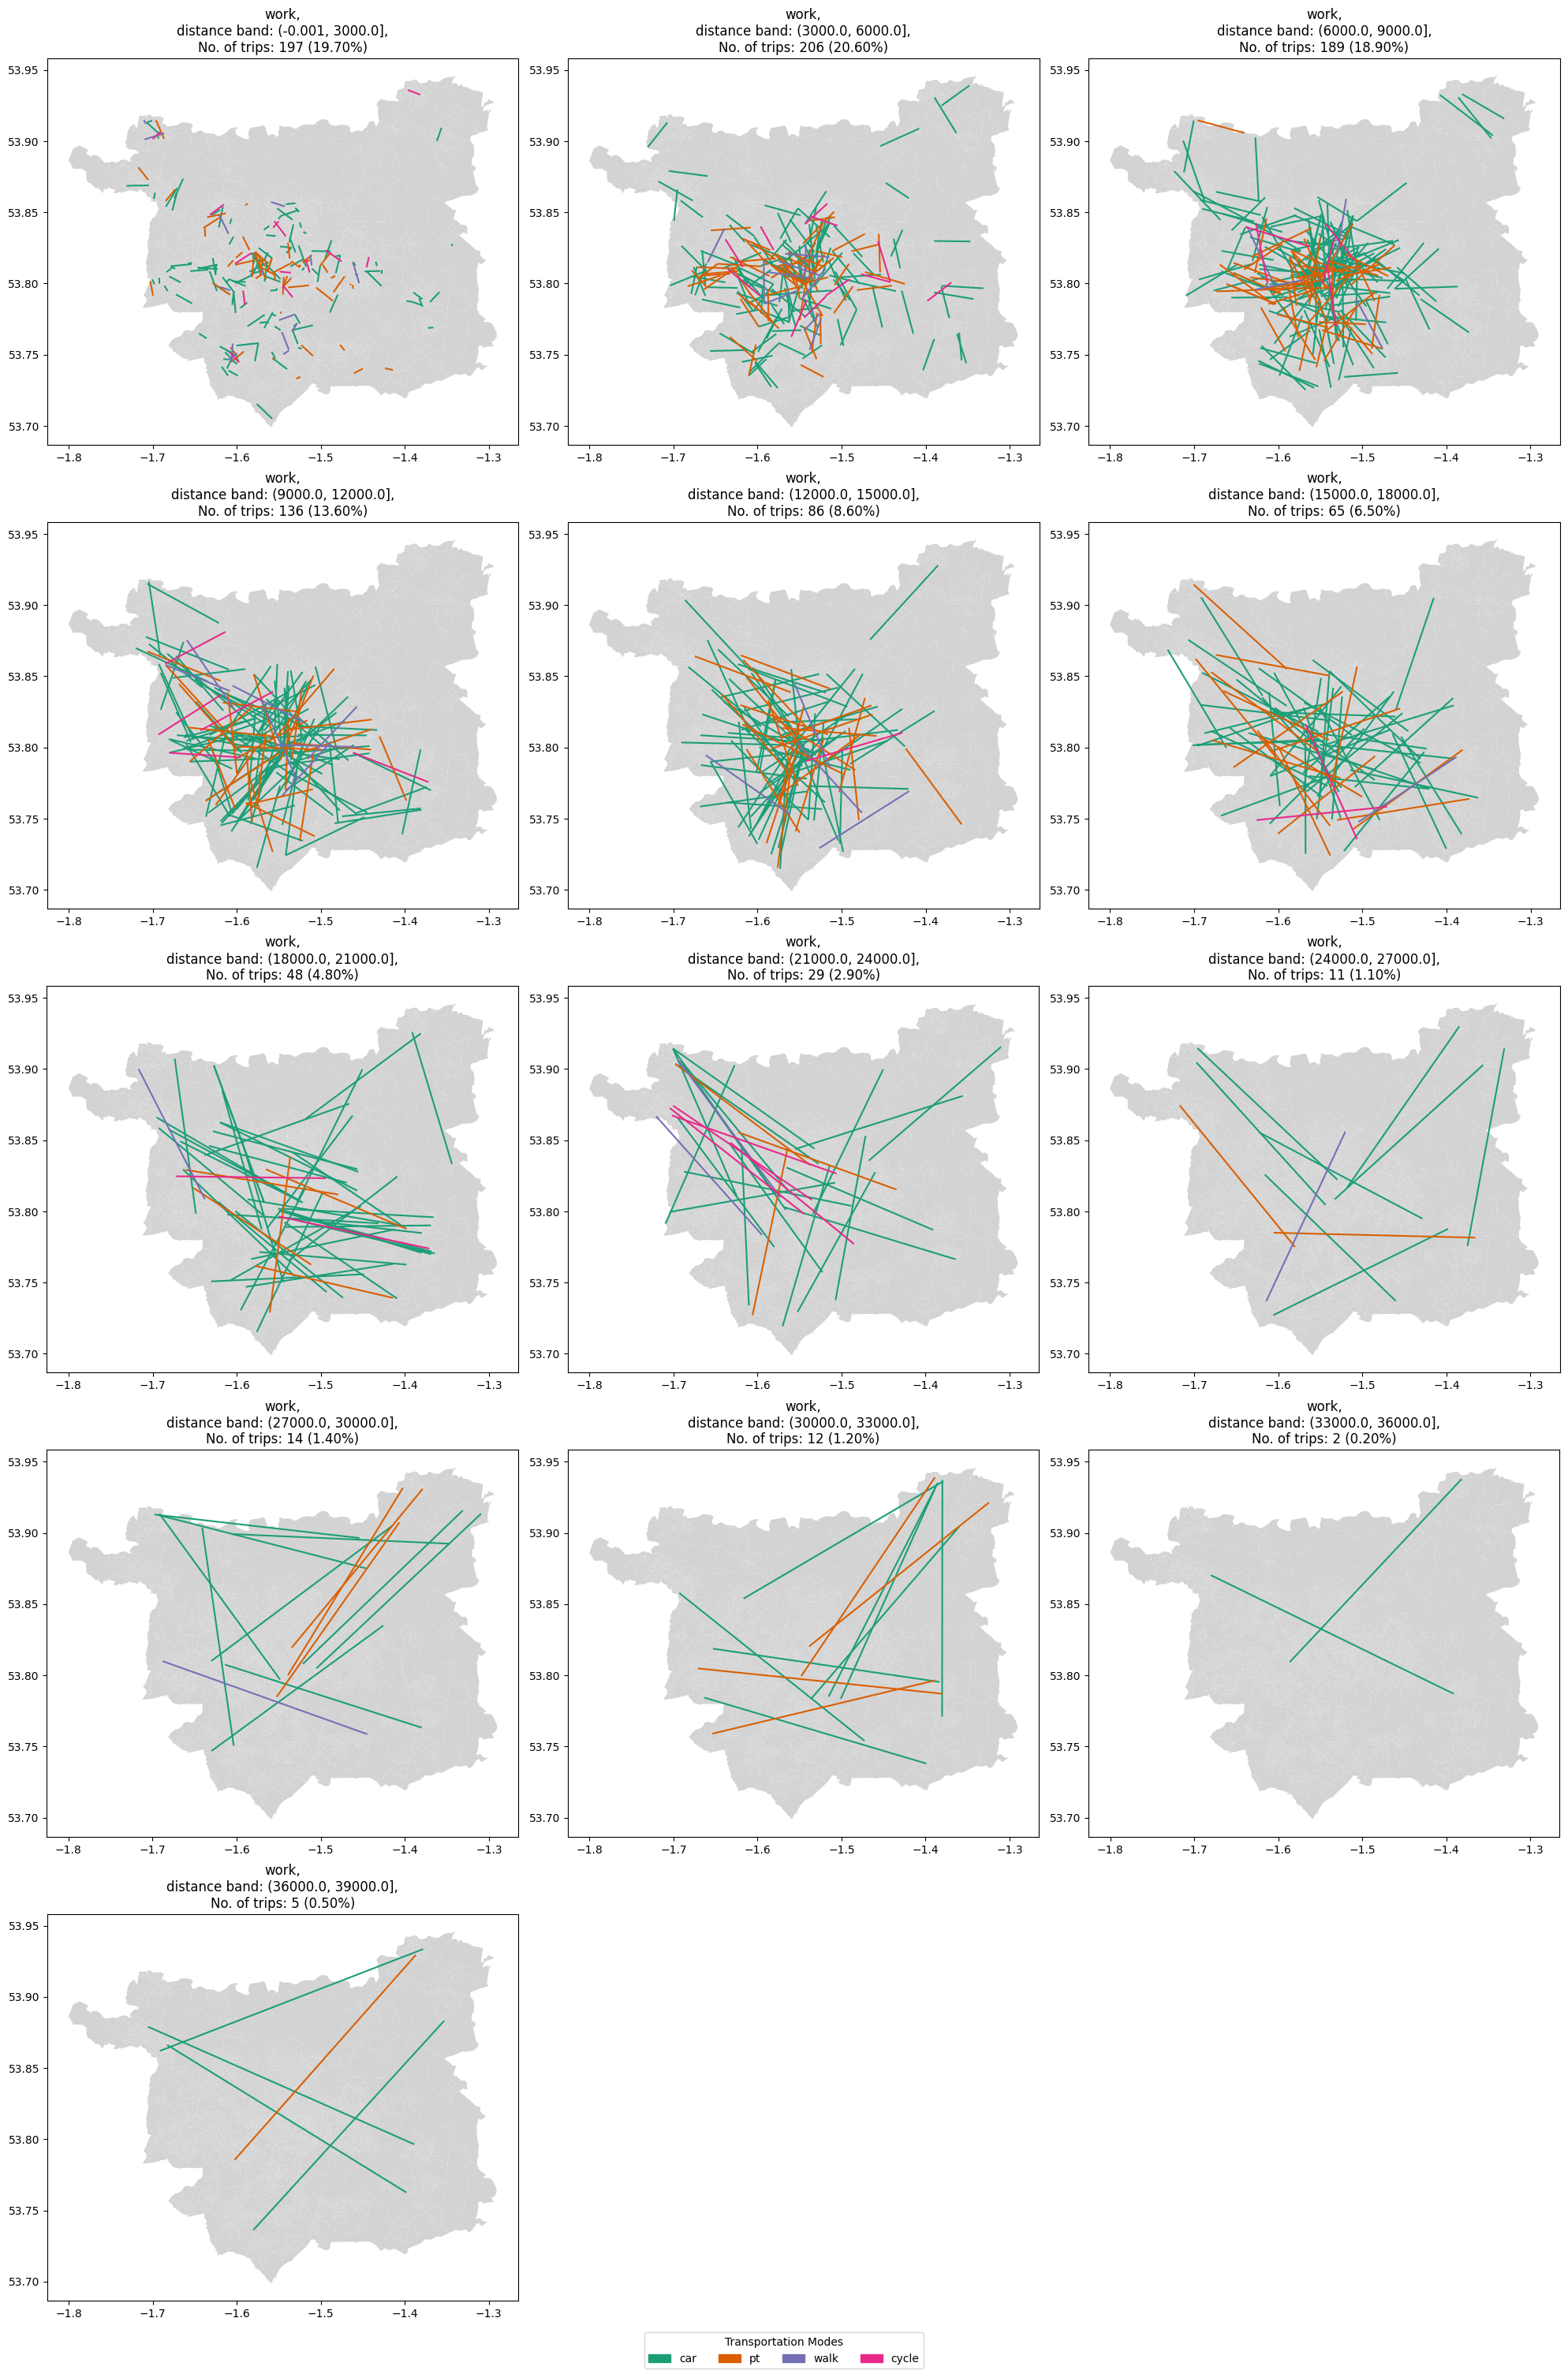

In [156]:
plot_activity_chains(activities=activity_chains_plot,
                     activity_type_col="dact",
                     activity_type="work",
                     bin_size=3000,
                     boundaries=boundaries,
                     sample_size = 1000)


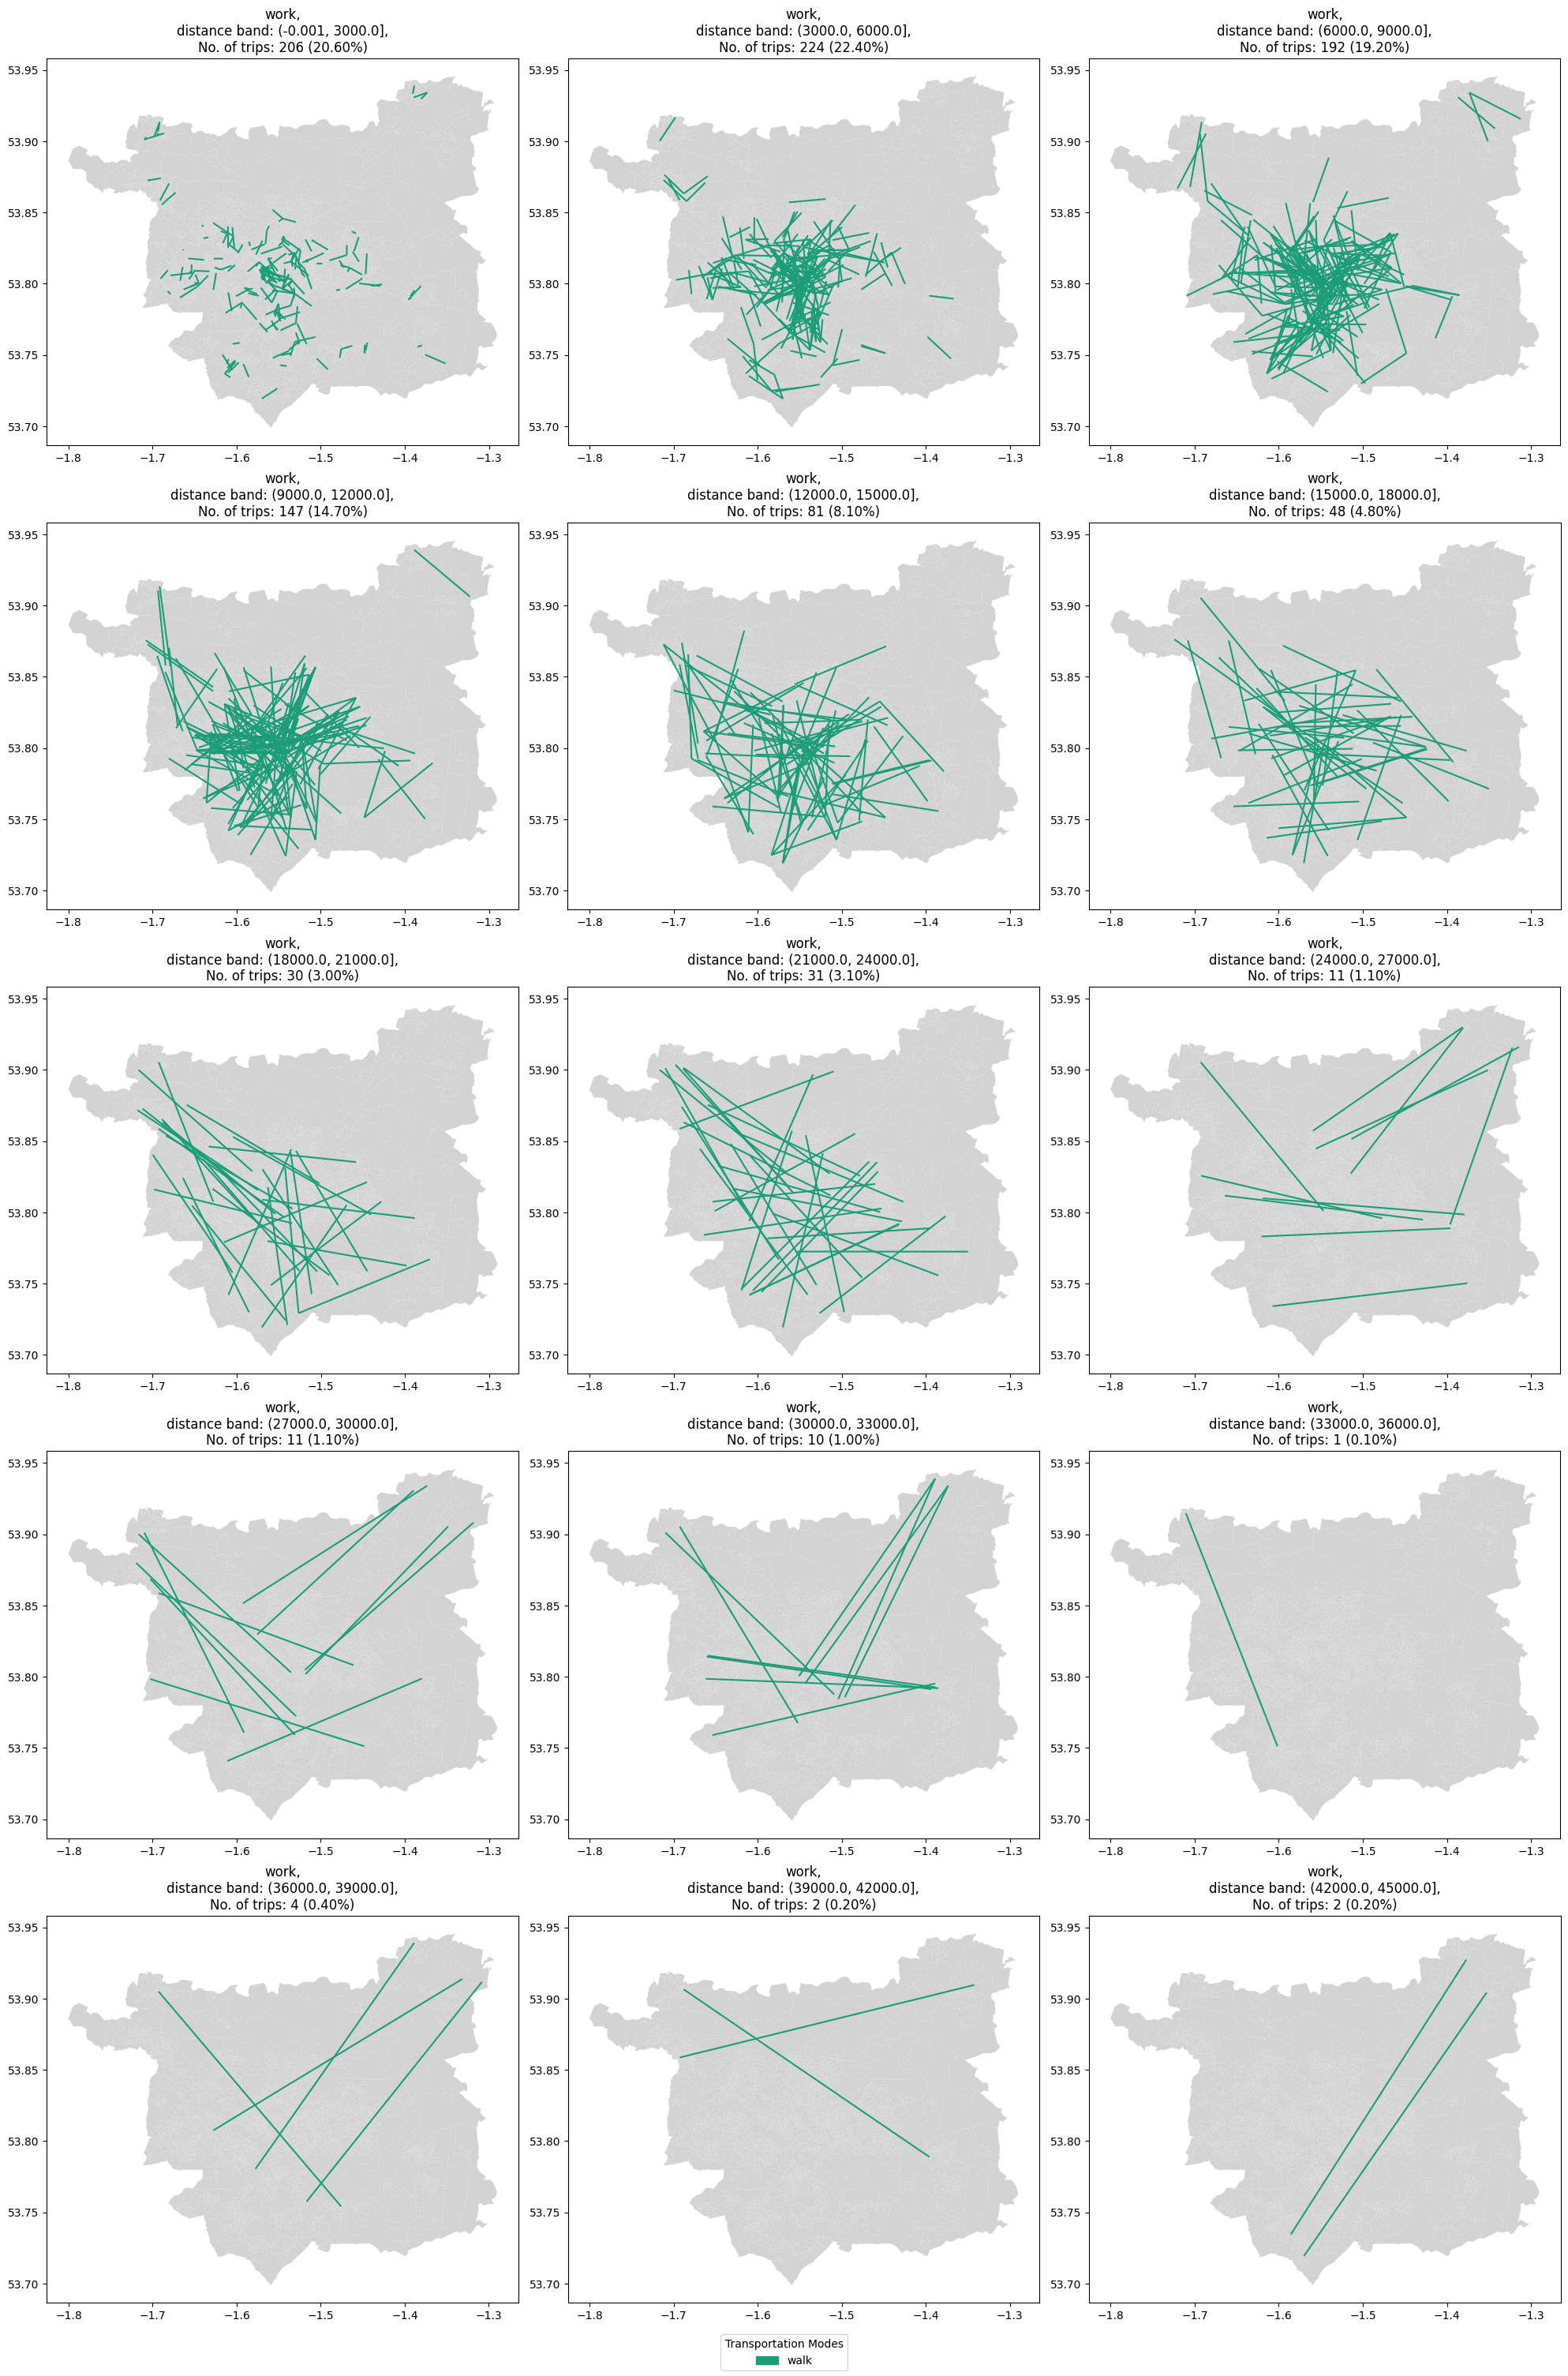

In [157]:
activity_chains_plot_walk = activity_chains_plot[activity_chains_plot['mode'] == 'walk']

plot_activity_chains(activities=activity_chains_plot_walk,
                     activity_type_col="dact",
                     activity_type="work",
                     bin_size=3000,
                     boundaries=boundaries,
                     sample_size = 1000)

##### Bar Plots

In [162]:
activity_chains_plot


id  household                   location   pid_hs       msoa  \
0       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
1       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
2       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
3       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
4       1193224     479418  POINT (-1.38883 53.93903)  2906516  E02002330   
...         ...        ...                        ...      ...        ...   
153207  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
153208  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
153209  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
153210  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   
153211  2339664     963311  POINT (-1.52227 53.76957)  2911183  E02006876   

               oa                      members sic1d2007  sic2d2007  pwkstat  \
0       E00059011           [1193224, 1193225]         C       25.0        6   
1       E00059011           [1193224, 1193225]         C       25.0        6   
2       E00059011           [1193224, 1193225]         C       25.0        6   
3       E00059011           [1193224, 1193225]         C       25.0        6   
4       E00059011           [1193224, 1193225]         C       25.0        6   
...           ...                          ...       ...        ...      ...   
153207  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
153208  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
153209  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
153210  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   
153211  E00057799  [2339664, 2339665, 2339666]         G       45.0        4   

        salary_yearly  salary_hourly             hid  accommodation_type  \
0                 NaN            NaN  E02002330_0109                 1.0   
1                 NaN            NaN  E02002330_0109                 1.0   
2                 NaN            NaN  E02002330_0109                 1.0   
3                 NaN            NaN  E02002330_0109                 1.0   
4                 NaN            NaN  E02002330_0109                 1.0   
...               ...            ...             ...                 ...   
153207            NaN            NaN  E02006876_3513                 3.0   
153208            NaN            NaN  E02006876_3513                 3.0   
153209            NaN            NaN  E02006876_3513                 3.0   
153210            NaN            NaN  E02006876_3513                 3.0   
153211            NaN            NaN  E02006876_3513                 3.0   

        communal_type  num_rooms  central_heat  tenure  num_cars  sex  \
0                 NaN        6.0          True     1.0         1    1   
1                 NaN        6.0          True     1.0         1    1   
2                 NaN        6.0          True     1.0         1    1   
3                 NaN        6.0          True     1.0         1    1   
4                 NaN        6.0          True     1.0         1    1   
...               ...        ...           ...     ...       ...  ...   
153207            NaN        4.0          True     2.0         2    1   
153208            NaN        4.0          True     2.0         2    1   
153209            NaN        4.0          True     2.0         2    1   
153210            NaN        4.0          True     2.0         2    1   
153211            NaN        4.0          True     2.0         2    1   

        age_years  ethnicity  nssec8  salary_yearly_hh  salary_yearly_hh_cat  \
0              71          1     4.0          0.000000                     1   
1              71          1     4.0          0.000000                     1   
2              71          1     4.0          0.000000                     1   
3              71

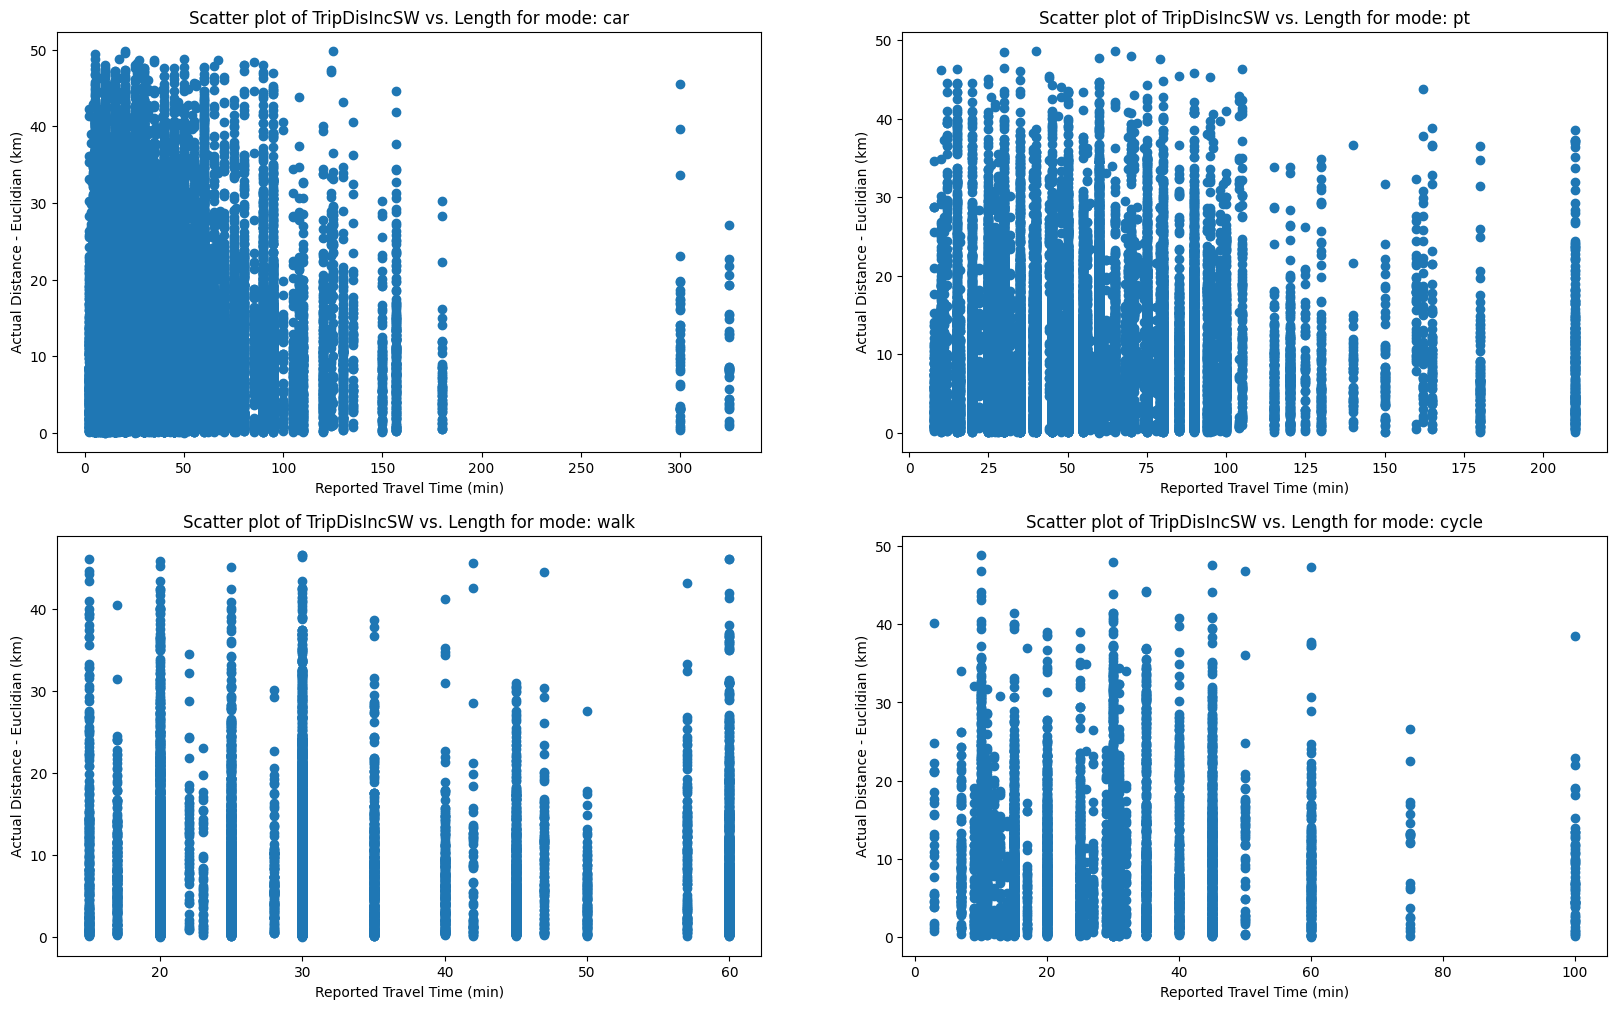

In [59]:
import matplotlib.pyplot as plt

# Calculate the number of rows and columns for the subplots. It is a function of the number of modes
nrows = math.ceil(len(activity_chains_plot['mode'].unique()) / 2)
ncols = 2

# Create a grid of subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 6 * nrows))

# Flatten axs for easy iteration
axs = axs.flatten()

# Create a scatter plot for each mode
for i, mode in enumerate(activity_chains_plot['mode'].unique()):
    # Get the subset for this mode
    subset_mode = activity_chains_plot[activity_chains_plot['mode'] == mode]

    # Plot the scatter plot
    ax = axs[i]
    ax.scatter(subset_mode['TripTotalTime'], subset_mode['length']/1000)  # Use a single color for all plots
    ax.set_title(f'Scatter plot of TripTotalTime vs. Length for mode: {mode}')
    ax.set_xlabel('Reported Travel Time (min)')  # Adjusted to km for clarity
    ax.set_ylabel('Actual Distance - Euclidian (km)')